#                                >> BANK GOOD CREDIT <<
#                                      PRCL-0015

## -- INTRODUCTION:

### Bank credit is usually referred to as a loan given for business requirements or personal needs to its customers, with or without a guarantee or collateral, with an expectation of earning periodic interest on the loan amount. The principal amount is refunded at the end of loan tenure, duly agreed upon, and mentioned in the loan covenant.

# -- Business case:

### Bank GoodCredit wants to predict cred score for current credit card customers.
### The cred score will denote a customer’s credit worthiness and help the bank in reducing credit default risk. 

### Target variable → Bad_label
### 0 – Customer has Good credit history
### 1 – Customer has Bad credit history (falls into 30 DPD + bucket)

## PROJECT GOAL: 
### Build a model with the data provided 
### 1. Data exploration insights – what did you find and what decision
### did you take?
### 2. Feature matrix - List of features selected with gain
### 3. Model evaluation - Gini and rank ordering


### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings("ignore")
import mysql
from mysql import connector
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import math
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report,roc_auc_score
from sklearn.model_selection import cross_val_score

### making connections to database server

In [2]:
connection = mysql.connector.connect(host ='18.136.157.135', 
                                     port='3306',
                                    user ='dm_team1', 
                                    password ='DM!$Team&279@20!',
                                    database ='project_banking')

### Check the number of databases available on the server

In [3]:
cursor=connection.cursor()
cursor.execute('show databases')
for i in cursor:
    print(i)

('information_schema',)
('project_banking',)


### displaying all tables present in the dataset

In [4]:
database_tables=pd.read_sql_query('show tables',connection) 
print(database_tables)

  Tables_in_project_banking
0              Cust_Account
1         Cust_Demographics
2              Cust_Enquiry


## Customers Account Table

In [5]:
query_1='select *from Cust_Account'
d1=pd.read_sql(query_1,connection)
pd.set_option('display.max_columns',None)
print(d1.shape)
d1.head()

(186329, 21)


,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900,0,,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",,01-Sep-15,01-Jul-14,,,,,
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,,03-Oct-15,16201,10390,,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000,1400,,3,5603
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,,30-Sep-15,41028,34420,,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,,,,,
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,,26-Jul-07,31-Jan-09,93473,0,,"""""""1200900600600600300000000000000000000000000...",,01-Jul-07,01-Feb-06,,,,,
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,,31-May-15,20250,13500,,"""""""000000000000000""""""",,01-May-15,01-Jan-15,,,,,


In [6]:
a=d1.groupby(["customer_no"])
d=pd.DataFrame(a.sum()).reset_index()
d.to_csv("Cust_Account")
data1=pd.read_csv("Cust_Account")


In [7]:
# Selecting required columns
data1.drop(['Unnamed: 0','acct_type',
       'owner_indic', 'opened_dt', 'last_paymt_dt', 'closed_dt',
       'reporting_dt',  'amt_past_due',
       'paymenthistory1', 'paymenthistory2', 'paymt_str_dt', 'paymt_end_dt','rateofinterest', 'paymentfrequency',
       'actualpaymentamount','dt_opened','upload_dt','acct_type'],axis=1,inplace=True)

In [8]:
data1.head()

,customer_no,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,2528846125459139765171256290596200000020000009...,2528846588820003759832549017546780000093630000,250000420000,168000
1,10,1111113565675230005500000531458600000111851500...,068994000178725000000,405000,243000
2,100,747754333541229800010000454945000034240350000,3970033460980316015530000,300009800059000,980017700
3,1000,548289548289147688,31349029113,225000270000,6750081000
4,10000,52590480000562501997410200520000,1752758222031250-26123003454770,60000,10000


## Customer Demographics Table 

In [9]:
query_2 = 'select *from Cust_Demographics'
d2=pd.read_sql(query_2,connection)
pd.set_option('display.max_columns',None)
print(d2.shape)
d2.head()

(23896, 83)


,dt_opened,customer_no,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,18-Apr-15,1,13-Apr-15,Insignia,13-Apr-15,650,2,Card Setup,14,500000,,,,Y,IS1,,0,159,4284,4284,,1,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1,2,,Mumbai / Navi Mumbai / Thane,400610,1965,0,Self,Y,2,90000,,,,0,0,0,0,Mumbai,400059,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,,Y,State Bank of India,0,01-Jun-13,17-Jun-16,1,21,,Y,Y,N,,Y,1965-0,21,15,400610,0,2,90000,Nov-00,21,R,,,0000-00-00,0,98332XXXXX,1,N,0
1,21-Apr-15,2,21-Apr-15,Insignia,21-Apr-15,760,1,Card Setup,14,1200000,,,,Y,IS1,,0,91,B001,4077,,1,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,@GMAIL.COM,1,2,,Bengaluru,560042,1969,0,Self,Y,2,1,,,,0,0,0,0,Bangalore,560042,,PAN Card,AJWPRXXXXX,The Ratnakar Bank Ltd.,,N,,0,,17-Jun-16,1,17,,Y,Y,N,,Y,1969-0,17,12,560042,0,2,1,Nov-00,17,R,,,0000-00-00,0,99455XXXXX,1,N,0
2,22-Apr-15,3,21-Apr-15,Insignia,21-Apr-15,774,1,Card Setup,14,700000,,,,Y,IS1,,0,91,B001,4077,,2,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,@SHOBANARAYAN.COM,1,0,,Bengaluru,560042,1966,0,Self,Y,2,1,,,,0,0,0,0,Bangalore,560042,,PAN Card,AFAPNXXXXX,,,N,,0,,17-Jun-16,3,17,,N,Y,N,,Y,1966-0,17,12,560042,0,2,1,Nov-00,17,R,,,0000-00-00,0,98456XXXXX,1,N,0
3,25-Apr-15,4,15-Apr-15,Insignia,20-Apr-15,770,1,Card Setup,14,500000,,,,Y,IS1,,0,157,5107,5107,,1,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,@VSNL.COM,1,3,,Pune,411001,1988,0,Self,Y,2,100000,,,,0,0,0,0,Pune,411026,@ALBAJ.COM,PAN Card,AAAPDXXXXX,The Ratnakar Bank Ltd.,,Y,HDFC Bank,0,,17-Jun-16,1,21,,Y,Y,N,,Y,1988-0,21,16,411001,0,2,100000,Nov-00,21,R,,,6/15/65,1,98220XXXXX,1,N,0
4,06-May-15,5,30-Apr-15,Insignia,,,3,Card Setup,14,500000,,,,Y,IS1,,0,100,D016,4564,,1,ABEPSXXXXX,03-Jan-54,98111XXXXX,N,@REDIFFMAIL.COM,1,3,,Gurgaon,122009,1995,0,Self,Y,2,300000,,,,0,0,0,0,Gurgaon,122009,,PAN Card,ABEPSXXXXX,The Ratnakar Bank Ltd.,,N,,0,,17-Jun-16,1,13,,Y,Y,N,,Y,1995-0,13,3,122009,0,2,300000,Nov-00,13,R,,,0000-00-00,0,98111XXXXX,1,N,0


In [10]:
b=d2.groupby(["customer_no"])
d1=pd.DataFrame(b.sum()).reset_index()
d1.to_csv("Cust_Demo")
data2=pd.read_csv("Cust_Demo")
data2.head()

,Unnamed: 0,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
0,0,1,18-Apr-15,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0
1,1,10,30-May-15,27-May-15,Insignia,27-May-15,784.0,1.0,Card Setup,14.0,1017000.0,NaN,NaN,NaN,Y,IS2,NaN,0.0,88,5785,5785,NaN,1.0,AAFPDXXXXX,09-Oct-69,98100XXXXX,N,NaN,1.0,3.0,NaN,Gurgaon,122011.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400025.0,NaN,PAN Card,AAFPDXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,1969-0,13.0,3.0,122011.0,0.0,2.0,1.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98100XXXXX,1.0,N,0
2,2,100,24-Apr-15,13-Apr-15,Titanium Deligh,13-Apr-15,780.0,3.0,Card Setup,14.0,137000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,BIAPSXXXXX,30-Jun-83,97186XXXXX,N,@GMAIL.COM,1.0,2.0,Post-Graduate,New Delhi,110071.0,1995.0,0.0,Self,Y,1.0,40000.0,Private Ltd. Co.,Others,ENGINEER,2010.0,1.0,10.0,0.0,Gurgaon,122001.0,@PAHWA.COM,PAN Card,BIAPSXXXXX,NaN,NaN,Y,State Bank of India,59000.0,01-May-11,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1995-0,10.0,157.0,110071.0,0.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,97186XXXXX,1.0,N,0
3,3,1000,28-May-15,08-May-15,Titanium Deligh,08-May-15,780.0,3.0,Card Setup,14.0,293000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,CGSPSXXXXX,01-Jan-72,99113XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,Post-Graduate,Gurgaon,122001.0,2011.0,0.0,Rente,N,1.0,40000.0,Private Ltd. Co.,Banking/Financial Services,SR ACCOUNTANT,2007.0,1.0,11.0,0.0,Gurgaon,122002.0,@HEMKUNTINFRATECH.COM,PAN Card,CGSPSXXXXX,NaN,NaN,Y,State Bank of India,225000.0,01-May-11,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,2011-0,26.0,226.0,754004.0,1.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,99113XXXXX,2.0,N,0
4,4,10000,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,700.0,3.0,Card Setup,14.0,145000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS32,NaN,NaN,1.0,DFIPKXXXXX,12-May-89,99109XXXXX,N,@GMAIL.COM,1.0,0.0,Graduate,New Delhi,110037.0,2006.0,1.0,Rente,N,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,New Delhi,110037.0,NaN,PAN Card,DFIPKXXXXX,NaN,NaN,Y,Citibank N.A.,0.0,01-Feb-13,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,2006-1,5.0,283.0,843118.0,1.0,2.0,1.0,Nov-00,10.0,O,NaN,NaN,0000-00-00,0.0,XXXXX,1.0,N,0


## Customer Enquiry Table

In [11]:
query_3 = 'select *from Cust_Enquiry'
d3= pd.read_sql(query_3,connection)
pd.set_option('display.max_columns',None)
print(d3.shape)
d3.head()

(413188, 6)


,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2,3500000
1,18-Apr-15,1,21-Apr-15,05-Mar-14,5,500000
2,18-Apr-15,1,21-Apr-15,05-Mar-14,0,50000
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10,50000
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10,1000


In [12]:
c=d3.groupby(["customer_no"])
d3=pd.DataFrame(c.sum()).reset_index()
d3.to_csv("Cust_Enquiry")
data3=pd.read_csv("Cust_Enquiry")


In [13]:
# Selecting required columns
data3.drop(['Unnamed: 0','dt_opened', 'upload_dt', 'enquiry_dt',
       'enq_purpose'],axis=1,inplace=True)

In [14]:
# Merging all 3 dataset
data=data2.merge(data3,on='customer_no')
df=data.merge(data1,on='customer_no')
df.head(pd.set_option("display.max_column",None))

,Unnamed: 0,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,0,1,18-Apr-15,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0,3500000500000500005000010001000100010001000150...,2528846125459139765171256290596200000020000009...,2528846588820003759832549017546780000093630000,250000420000,168000
1,1,10,30-May-15,27-May-15,Insignia,27-May-15,784.0,1.0,Card Setup,14.0,1017000.0,NaN,NaN,NaN,Y,IS2,NaN,0.0,88,5785,5785,NaN,1.0,AAFPDXXXXX,09-Oct-69,98100XXXXX,N,NaN,1.0,3.0,NaN,Gurgaon,122011.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400025.0,NaN,PAN Card,AAFPDXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,1969-0,13.0,3.0,122011.0,0.0,2.0,1.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98100XXXXX,1.0,N,0,2000000200000002000000055000005500000100050000...,1111113565675230005500000531458600000111851500...,068994000178725000000,405000,243000
2,2,100,24-Apr-15,13-Apr-15,Titanium Deligh,13-Apr-15,780.0,3.0,Card Setup,14.0,137000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,BIAPSXXXXX,30-Jun-83,97186XXXXX,N,@GMAIL.COM,1.0,2.0,Post-Graduate,New Delhi,110071.0,1995.0,0.0,Self,Y,1.0,40000.0,Private Ltd. Co.,Others,ENGINEER,2010.0,1.0,10.0,0.0,Gurgaon,122001.0,@PAHWA.COM,PAN Card,BIAPSXXXXX,NaN,NaN,Y,State Bank of India,59000.0,01-May-11,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1995-0,10.0,157.0,110071.0,0.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,97186XXXXX,1.0,N,0,5000010000110000130000030000040000010000100001...,747754333541229800010000454945000034240350000,3970033460980316015530000,300009800059000,980017700
3,3,1000,28-May-15,08-May-15,Titanium Deligh,08-May-15,780.0,3.0,Card Setup,14.0,293000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,CGSPSXXXXX,01-Jan-72,99113XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,Post-Graduate,Gurgaon,122001.0,2011.0,0.0,Rente,N,1.0,40000.0,Private Ltd. Co.,Banking/Financial Services,SR ACCOUNTANT,2007.0,1.0,11.0,0.0,Gurgaon,122002.0,@HEMKUNTINFRATECH.COM,PAN Card,CGSPSXXXXX,NaN,NaN,Y,State Bank of India,225000.0,01-May-11,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,2011-0,26.0,226.0,754004.0,1.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,99113XXXXX,2.0,N,0,10000100010000100001000050000500005000010001000,548289548289147688,31349029113,225000270000,6750081000
4,4,10000,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,700.0,3.0,Card Setup,14.0,145000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS32,NaN,NaN,1.0,DFIPKXXXXX,12-May-89,99109XXXXX,N,@GMAIL.COM,1.0,0.0,Graduate,New Delhi,110037.0,2006.0,1.0,Rente,N,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,New Delhi,110037.0,NaN,PAN Card,DFIPKXXXXX,NaN,NaN,Y,Citibank N.A.,0.0,01-Feb-13,17-Jun-16,1.0,10.0,NaN,N,Y,N,

In [15]:
df.drop("Unnamed: 0",axis=1,inplace=True) # Dropping unwanted column

# Basic Checks

In [16]:
df.head() # displays initial 5 rows

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,18-Apr-15,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0,3500000500000500005000010001000100010001000150...,2528846125459139765171256290596200000020000009...,2528846588820003759832549017546780000093630000,250000420000,168000
1,10,30-May-15,27-May-15,Insignia,27-May-15,784.0,1.0,Card Setup,14.0,1017000.0,NaN,NaN,NaN,Y,IS2,NaN,0.0,88,5785,5785,NaN,1.0,AAFPDXXXXX,09-Oct-69,98100XXXXX,N,NaN,1.0,3.0,NaN,Gurgaon,122011.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400025.0,NaN,PAN Card,AAFPDXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,1969-0,13.0,3.0,122011.0,0.0,2.0,1.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98100XXXXX,1.0,N,0,2000000200000002000000055000005500000100050000...,1111113565675230005500000531458600000111851500...,068994000178725000000,405000,243000
2,100,24-Apr-15,13-Apr-15,Titanium Deligh,13-Apr-15,780.0,3.0,Card Setup,14.0,137000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,BIAPSXXXXX,30-Jun-83,97186XXXXX,N,@GMAIL.COM,1.0,2.0,Post-Graduate,New Delhi,110071.0,1995.0,0.0,Self,Y,1.0,40000.0,Private Ltd. Co.,Others,ENGINEER,2010.0,1.0,10.0,0.0,Gurgaon,122001.0,@PAHWA.COM,PAN Card,BIAPSXXXXX,NaN,NaN,Y,State Bank of India,59000.0,01-May-11,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1995-0,10.0,157.0,110071.0,0.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,97186XXXXX,1.0,N,0,5000010000110000130000030000040000010000100001...,747754333541229800010000454945000034240350000,3970033460980316015530000,300009800059000,980017700
3,1000,28-May-15,08-May-15,Titanium Deligh,08-May-15,780.0,3.0,Card Setup,14.0,293000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,CGSPSXXXXX,01-Jan-72,99113XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,Post-Graduate,Gurgaon,122001.0,2011.0,0.0,Rente,N,1.0,40000.0,Private Ltd. Co.,Banking/Financial Services,SR ACCOUNTANT,2007.0,1.0,11.0,0.0,Gurgaon,122002.0,@HEMKUNTINFRATECH.COM,PAN Card,CGSPSXXXXX,NaN,NaN,Y,State Bank of India,225000.0,01-May-11,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,2011-0,26.0,226.0,754004.0,1.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,99113XXXXX,2.0,N,0,10000100010000100001000050000500005000010001000,548289548289147688,31349029113,225000270000,6750081000
4,10000,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,700.0,3.0,Card Setup,14.0,145000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS32,NaN,NaN,1.0,DFIPKXXXXX,12-May-89,99109XXXXX,N,@GMAIL.COM,1.0,0.0,Graduate,New Delhi,110037.0,2006.0,1.0,Rente,N,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,New Delhi,110037.0,NaN,PAN Card,DFIPKXXXXX,NaN,NaN,Y,Citibank N.A.,0.0,01-Feb-13,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,2006-1,5.0,283.

In [17]:
df.tail() # displays final 5 rows

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
23891,9995,30-Sep-15,28-Aug-15,Platinum Maxima,28-Aug-15,676.0,3.0,Card Setup,14.0,65000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA05,MA01,NaN,NaN,1.0,BXFPKXXXXX,25-Aug-87,99993XXXXX,N,@YAHOO.IN,1.0,0.0,Post-Graduate,New Delhi,110059.0,1988.0,0.0,Paren,Y,1.0,31000.0,MNC,Banking/Financial Services,ASST MANAGER,2012.0,3.0,5.0,0.0,New Delhi,110016.0,@MEGASOFTSOL.COM,PAN Card,BXFPKXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1988-0,10.0,157.0,110059.0,0.0,1.0,31000.0,0-0,10.0,O,NaN,NaN,0000-00-00,0.0,99993XXXXX,1.0,N,1,1000050000150000500001500001000010000100005000...,124964496733869524900038822,117236492223702016887613554,4900038800,9800
23892,9996,30-Sep-15,20-Sep-15,Platinum Maxima,21-Sep-15,732.0,1.0,Card Setup,14.0,127000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,CD01,D073,NaN,NaN,1.0,BPBPRXXXXX,12-Jun-83,97118XXXXX,N,@GMAIL.COM,1.0,0.0,NaN,New Delhi,110005.0,1983.0,0.0,Paren,Y,1.0,1.0,Public Ltd Co.,Banking/Financial Services,SRM,2013.0,9.0,10.0,0.0,New Delhi,110065.0,NaN,PAN Card,BPBPRXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1983-0,10.0,157.0,110005.0,0.0,1.0,1.0,0-0,10.0,O,NaN,NaN,0000-00-00,0.0,97118XXXXX,1.0,N,0,1000004400044000500001500005000010001000,44000977215000031516,4400033111263042843,65000,13000
23893,9997,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,737.0,1.0,Card Setup,14.0,91000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,PA15,D073,NaN,NaN,1.0,AMYPMXXXXX,15-Jan-82,98718XXXXX,Y,@GMAIL.COM,1.0,0.0,Graduate,New Delhi,110044.0,2005.0,0.0,Paren,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,New Delhi,110044.0,NaN,PAN Card,AMYPMXXXXX,NaN,NaN,Y,HDFC Bank,0.0,01-Apr-14,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,2005-0,10.0,157.0,110044.0,0.0,2.0,1.0,Nov-00,10.0,R,NaN,NaN,0000-00-00,0.0,98718XXXXX,1.0,N,0,1000050000150005000015000970005000010001500001...,22990100000175409959090000,00095830,NaN,NaN
23894,9998,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,700.0,3.0,Card Setup,14.0,96000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS32,NaN,NaN,1.0,BVHPSXXXXX,20-Jan-82,97114XXXXX,N,@REDIFMAIL.COM,1.0,0.0,Graduate,Gurgaon,122001.0,2011.0,0.0,Self,Y,1.0,1.0,Proprietorship,Banking/Financial Services,OPRATION,2008.0,1.0,0.0,0.0,Gurgaon,122002.0,NaN,PAN Card,BVHPSXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,2011-0,13.0,3.0,122001.0,0.0,1.0,1.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,97114XXXXX,1.0,N,0,50000500005000050000500001000,407621558523169,386371389419983,4100015000,4100
23895,9999,30-Sep-15,15-Sep-15,Platinum Maxima,15-Sep-15,731.0,3.0,Card Setup,14.0,80000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS33,NaN,NaN,1.0,ALVPJXXXXX,05-Jul-88,98119XXXXX,N,@GMAIL.COM,2.0,0.0,Graduate,New Delhi,110037.0,2012.0,0.0,Paren,Y,1.0,1.0,Private Ltd. Co.,Banking/Financial Services,FINANCE MANAGER,2011.0,9.0,4.0,0.0,New Delhi,110070.0,NaN,PAN Card,ALVPJXXXXX,NaN,NaN,Y,HDFC Bank,65000.0,01-Dec-13,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,2012-0,10.0,157.0,110037.0,0.0,1.0,1.0,0-0,10.0,O,NaN,NaN,0000-00-00,0.0,98119XXXXX,1.0,N,0,5000010000500001000001500050000100001000500005...,15275437582300022500441317500019718,0891009915

In [18]:
df.shape # displaying shape of the data

(23896, 88)

In [19]:
columns = list(df.columns) # list of all columns
print(columns)

['customer_no', 'dt_opened', 'entry_time', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 

In [20]:
df.describe() ## Statistical information about numerical data

,customer_no,feature_3,feature_4,feature_6,feature_7,feature_14,feature_19,feature_25,feature_26,feature_29,feature_30,feature_31,feature_34,feature_35,feature_39,feature_40,feature_41,feature_42,feature_44,feature_49,feature_52,feature_55,feature_56,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_71,feature_74,feature_76,feature_78,Bad_label
count,23896.000000,21060.000000,23881.000000,23881.0,2.388100e+04,16163.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,2.388100e+04,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,1.040000e+02,2.388100e+04,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,23881.000000,2.388100e+04,23881.000000,17.000000,23881.000000,23881.000000,23896.000000
mean,11948.500000,723.235945,2.321595,14.0,1.190705e+05,8.086618,1.049412,1.233910,0.725640,217620.229346,2001.183996,0.652318,1.238851,3.278933e+04,1533.268707,3.348352,5.702609,0.154139,222251.238474,2.724312e+11,6.500073e+04,1.085717,13.337465,14.587454,157.609732,264374.021440,0.184373,1.238851,3.278933e+04,14.539048,2.411765,0.003852,1.043214,0.042015
std,6898.325352,37.318684,0.892838,0.0,7.752349e+04,5.625654,0.216731,0.423324,1.124986,159267.102213,11.993426,2.343709,0.430009,1.087860e+05,855.273257,3.587043,4.159316,0.930806,156846.154943,1.223114e+11,1.008225e+05,0.388569,8.285993,9.518517,190.979066,202001.890433,0.387796,0.430009,1.087860e+05,9.077906,0.618347,0.084286,0.224672,0.200628
min,1.000000,-1.000000,1.000000,14.0,0.000000e+00,0.000000,1.000000,1.000000,0.000000,110001.000000,1964.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,7.568570e+05,0.000000e+00,1.000000,2.000000,2.000000,1.000000,110001.000000,0.000000,1.000000,1.000000e+00,2.000000,2.000000,0.000000,1.000000,0.000000
25%,5974.750000,698.000000,1.000000,14.0,7.200000e+04,0.000000,1.000000,1.000000,0.000000,110051.000000,1991.000000,0.000000,1.000000,1.000000e+00,1999.000000,0.000000,1.000000,0.000000,110044.000000,3.090000e+11,0.000000e+00,1.000000,10.000000,10.000000,39.000000,110059.000000,0.000000,1.000000,1.000000e+00,10.000000,2.000000,0.000000,1.000000,0.000000
50%,11948.500000,721.000000,3.000000,14.0,1.040000e+05,12.000000,1.000000,1.000000,0.000000,110094.000000,2005.000000,0.000000,1.000000,3.000000e+04,2010.000000,2.000000,6.000000,0.000000,122001.000000,3.090000e+11,5.000000e+04,1.000000,10.000000,10.000000,157.000000,122012.000000,0.000000,1.000000,3.000000e+04,10.000000,2.000000,0.000000,1.000000,0.000000
75%,17922.250000,745.000000,3.000000,14.0,1.390000e+05,12.000000,1.000000,1.000000,2.000000,390002.000000,2011.000000,0.000000,1.000000,4.300000e+04,2013.000000,6.000000,10.000000,0.000000,390002.000000,3.090000e+11,1.000000e+05,1.000000,13.000000,21.000000,157.000000,400601.000000,0.000000,1.000000,4.300000e+04,17.000000,3.000000,0.000000,1.000000,0.000000
max,23896.000000,896.000000,3.000000,14.0,1.217000e+06,12.000000,2.000000,2.000000,10.000000,712245.000000,2015.000000,12.000000,3.000000,1.500000e+07,2015.000000,12.000000,11.000000,11.000000,712201.000000,8.090000e+11,3.777000e+06,4.000000,35.000000,35.000000,10008.000000,874401.000000,1.000000,3.000000,1.500000e+07,35.000000,4.000000,4.000000,3.000000,1.000000


#### feature_6 has standard deviation=0,which is corrupted data value,so we will replace it with median.

In [21]:
df.loc[df["feature_6"]==0,"feature_6"]=np.median(df["feature_6"])

In [22]:
df.describe(include="O") # Statistical information about  categorical features

,dt_opened,entry_time,feature_1,feature_2,feature_5,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_15,feature_16,feature_17,feature_18,feature_20,feature_21,feature_22,feature_23,feature_24,feature_27,feature_28,feature_32,feature_33,feature_36,feature_37,feature_38,feature_43,feature_45,feature_46,feature_47,feature_48,feature_50,feature_51,feature_53,feature_54,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_70,feature_72,feature_73,feature_75,feature_77,feature_79,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
count,23896,23881,23881,21060,23881,1261,1261,51,23881,23881,10892,23873,23869,1027,18,23896,23881,23896,23881,23256,20259,23881,23881,23881,18214,18214,18214,23881,10183,23802,23896,5497,23881,12474,12286,23881,2393,23881,23881,23881,9,23881,23881,23881,23881,2945,23881,23896,23881,23787,23883,23896,19872,18435
unique,197,296,7,281,1,19,19,9,2,16,14,364,522,302,12,10610,8462,3251,2,721,10,62,5,2,9,11,5663,70,4472,5,11250,56,2,10,180,1,2,2,2,2,8,2,491,133,2,2,62,3124,2,22265,23802,23627,10944,8286
top,16-Nov-15,19-Oct-15,Platinum Maxima,19-Oct-15,Card Setup,ROTVR,Negative Office Tele Verification,3.09E+11,Y,PM1,PD3,SA03,AS19,5622,180,AXMPKXXXXX,01-Jan-85,99999XXXXX,N,@GMAIL.COM,Graduate,New Delhi,Self,Y,Private Ltd. Co.,Banking/Financial Services,MANAGER,New Delhi,@GMAIL.COM,PAN Card,XXXXX,HDFC Bank,Y,HDFC Bank,01-Jun-14,17-Jun-16,Y,N,Y,N,GNWX-B,Y,2010-0,0-0,R,Y,0000-00-00,XXXXX,N,500001000,100000100000,0,50000,10000
freq,699,180,9056,182,23881,336,336,28,22611,8853,8416,9331,1374,169,5,16,33,194,21528,15595,14610,12539,10833,19478,8677,13187,1624,9760,1854,22796,94,1368,12565,5704,624,23881,2242,23425,22611,23563,2,23876,1670,18235,15617,2126,23820,2149,23876,212,13,73,369,652


In [23]:
df.info() # Quick summary of dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23896 entries, 0 to 23895
Data columns (total 88 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_no      23896 non-null  int64  
 1   dt_opened        23896 non-null  object 
 2   entry_time       23881 non-null  object 
 3   feature_1        23881 non-null  object 
 4   feature_2        21060 non-null  object 
 5   feature_3        21060 non-null  float64
 6   feature_4        23881 non-null  float64
 7   feature_5        23881 non-null  object 
 8   feature_6        23881 non-null  float64
 9   feature_7        23881 non-null  float64
 10  feature_8        1261 non-null   object 
 11  feature_9        1261 non-null   object 
 12  feature_10       51 non-null     object 
 13  feature_11       23881 non-null  object 
 14  feature_12       23881 non-null  object 
 15  feature_13       10892 non-null  object 
 16  feature_14       16163 non-null  float64
 17  feature_15  

In [24]:
df.duplicated().sum() # checking for duplicated records

0

### the dataset has no duplicate values

In [25]:
df.shape  # to get number of rows and columns after dropping duplicate records

(23896, 88)

In [26]:
## Counting the tagert variabe for each class
data.Bad_label.value_counts() # indicates imbalanced dataset

0    22892
1     1004
Name: Bad_label, dtype: int64

In [27]:
sample=df.loc[:100,:]
sample.head(pd.set_option("display.max_rows",None))

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,18-Apr-15,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,NaN,NaN,NaN,Y,IS1,NaN,0.0,159,4284,4284,NaN,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,@CODOGNOTTO.NET,PAN Card,ADFPNXXXXX,The Ratnakar Bank Ltd.,NaN,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,NaN,Y,Y,N,NaN,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98332XXXXX,1.0,N,0,3500000500000500005000010001000100010001000150...,2528846125459139765171256290596200000020000009...,2528846588820003759832549017546780000093630000,250000420000,168000
1,10,30-May-15,27-May-15,Insignia,27-May-15,784.0,1.0,Card Setup,14.0,1017000.0,NaN,NaN,NaN,Y,IS2,NaN,0.0,88,5785,5785,NaN,1.0,AAFPDXXXXX,09-Oct-69,98100XXXXX,N,NaN,1.0,3.0,NaN,Gurgaon,122011.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400025.0,NaN,PAN Card,AAFPDXXXXX,NaN,NaN,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,1969-0,13.0,3.0,122011.0,0.0,2.0,1.0,Nov-00,21.0,R,NaN,NaN,0000-00-00,0.0,98100XXXXX,1.0,N,0,2000000200000002000000055000005500000100050000...,1111113565675230005500000531458600000111851500...,068994000178725000000,405000,243000
2,100,24-Apr-15,13-Apr-15,Titanium Deligh,13-Apr-15,780.0,3.0,Card Setup,14.0,137000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,BIAPSXXXXX,30-Jun-83,97186XXXXX,N,@GMAIL.COM,1.0,2.0,Post-Graduate,New Delhi,110071.0,1995.0,0.0,Self,Y,1.0,40000.0,Private Ltd. Co.,Others,ENGINEER,2010.0,1.0,10.0,0.0,Gurgaon,122001.0,@PAHWA.COM,PAN Card,BIAPSXXXXX,NaN,NaN,Y,State Bank of India,59000.0,01-May-11,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,1995-0,10.0,157.0,110071.0,0.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,97186XXXXX,1.0,N,0,5000010000110000130000030000040000010000100001...,747754333541229800010000454945000034240350000,3970033460980316015530000,300009800059000,980017700
3,1000,28-May-15,08-May-15,Titanium Deligh,08-May-15,780.0,3.0,Card Setup,14.0,293000.0,NaN,NaN,NaN,Y,TD1,TD3,12.0,SA03,AS11,NaN,NaN,1.0,CGSPSXXXXX,01-Jan-72,99113XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,Post-Graduate,Gurgaon,122001.0,2011.0,0.0,Rente,N,1.0,40000.0,Private Ltd. Co.,Banking/Financial Services,SR ACCOUNTANT,2007.0,1.0,11.0,0.0,Gurgaon,122002.0,@HEMKUNTINFRATECH.COM,PAN Card,CGSPSXXXXX,NaN,NaN,Y,State Bank of India,225000.0,01-May-11,17-Jun-16,1.0,13.0,NaN,N,Y,N,NaN,Y,2011-0,26.0,226.0,754004.0,1.0,1.0,40000.0,0-0,13.0,O,NaN,NaN,0000-00-00,0.0,99113XXXXX,2.0,N,0,10000100010000100001000050000500005000010001000,548289548289147688,31349029113,225000270000,6750081000
4,10000,30-Sep-15,10-Sep-15,Platinum Maxima,10-Sep-15,700.0,3.0,Card Setup,14.0,145000.0,NaN,NaN,NaN,Y,PM1,NaN,NaN,SA03,AS32,NaN,NaN,1.0,DFIPKXXXXX,12-May-89,99109XXXXX,N,@GMAIL.COM,1.0,0.0,Graduate,New Delhi,110037.0,2006.0,1.0,Rente,N,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,New Delhi,110037.0,NaN,PAN Card,DFIPKXXXXX,NaN,NaN,Y,Citibank N.A.,0.0,01-Feb-13,17-Jun-16,1.0,10.0,NaN,N,Y,N,NaN,Y,2006-1,5.0,283.

In [28]:
df.dtypes # displaying datatypes of dataset

customer_no          int64
dt_opened           object
entry_time          object
feature_1           object
feature_2           object
feature_3          float64
feature_4          float64
feature_5           object
feature_6          float64
feature_7          float64
feature_8           object
feature_9           object
feature_10          object
feature_11          object
feature_12          object
feature_13          object
feature_14         float64
feature_15          object
feature_16          object
feature_17          object
feature_18          object
feature_19         float64
feature_20          object
feature_21          object
feature_22          object
feature_23          object
feature_24          object
feature_25         float64
feature_26         float64
feature_27          object
feature_28          object
feature_29         float64
feature_30         float64
feature_31         float64
feature_32          object
feature_33          object
feature_34         float64
f

# EDA (Exploratory Data Analysis)

### Getting numeric features

In [29]:
numeric_col=[] # Fetching numeric columns
for column in df.columns:
    if df[column].dtype=="int64":
        numeric_col.append(column)
np.array(numeric_col ) 

array(['customer_no', 'Bad_label'], dtype='<U11')

In [30]:
numeric_col=[]
for column in df.columns:
    if df[column].dtype=="float64":
        numeric_col.append(column)
np.array(numeric_col  )

array(['feature_3', 'feature_4', 'feature_6', 'feature_7', 'feature_14',
       'feature_19', 'feature_25', 'feature_26', 'feature_29',
       'feature_30', 'feature_31', 'feature_34', 'feature_35',
       'feature_39', 'feature_40', 'feature_41', 'feature_42',
       'feature_44', 'feature_49', 'feature_52', 'feature_55',
       'feature_56', 'feature_64', 'feature_65', 'feature_66',
       'feature_67', 'feature_68', 'feature_69', 'feature_71',
       'feature_74', 'feature_76', 'feature_78'], dtype='<U10')

In [31]:
data1=df[['customer_no', 'Bad_label','feature_3', 'feature_4', 'feature_6', 'feature_7', 'feature_14',
       'feature_19', 'feature_25', 'feature_26', 'feature_29',
       'feature_30', 'feature_31', 'feature_34', 'feature_35',
       'feature_39', 'feature_40', 'feature_41', 'feature_42',
       'feature_44', 'feature_49', 'feature_52', 'feature_55',
       'feature_56', 'feature_64', 'feature_65', 'feature_66',
       'feature_67', 'feature_68', 'feature_69', 'feature_71',
       'feature_74', 'feature_76', 'feature_78']]
data1.shape      

(23896, 34)

### Univariate Analysis

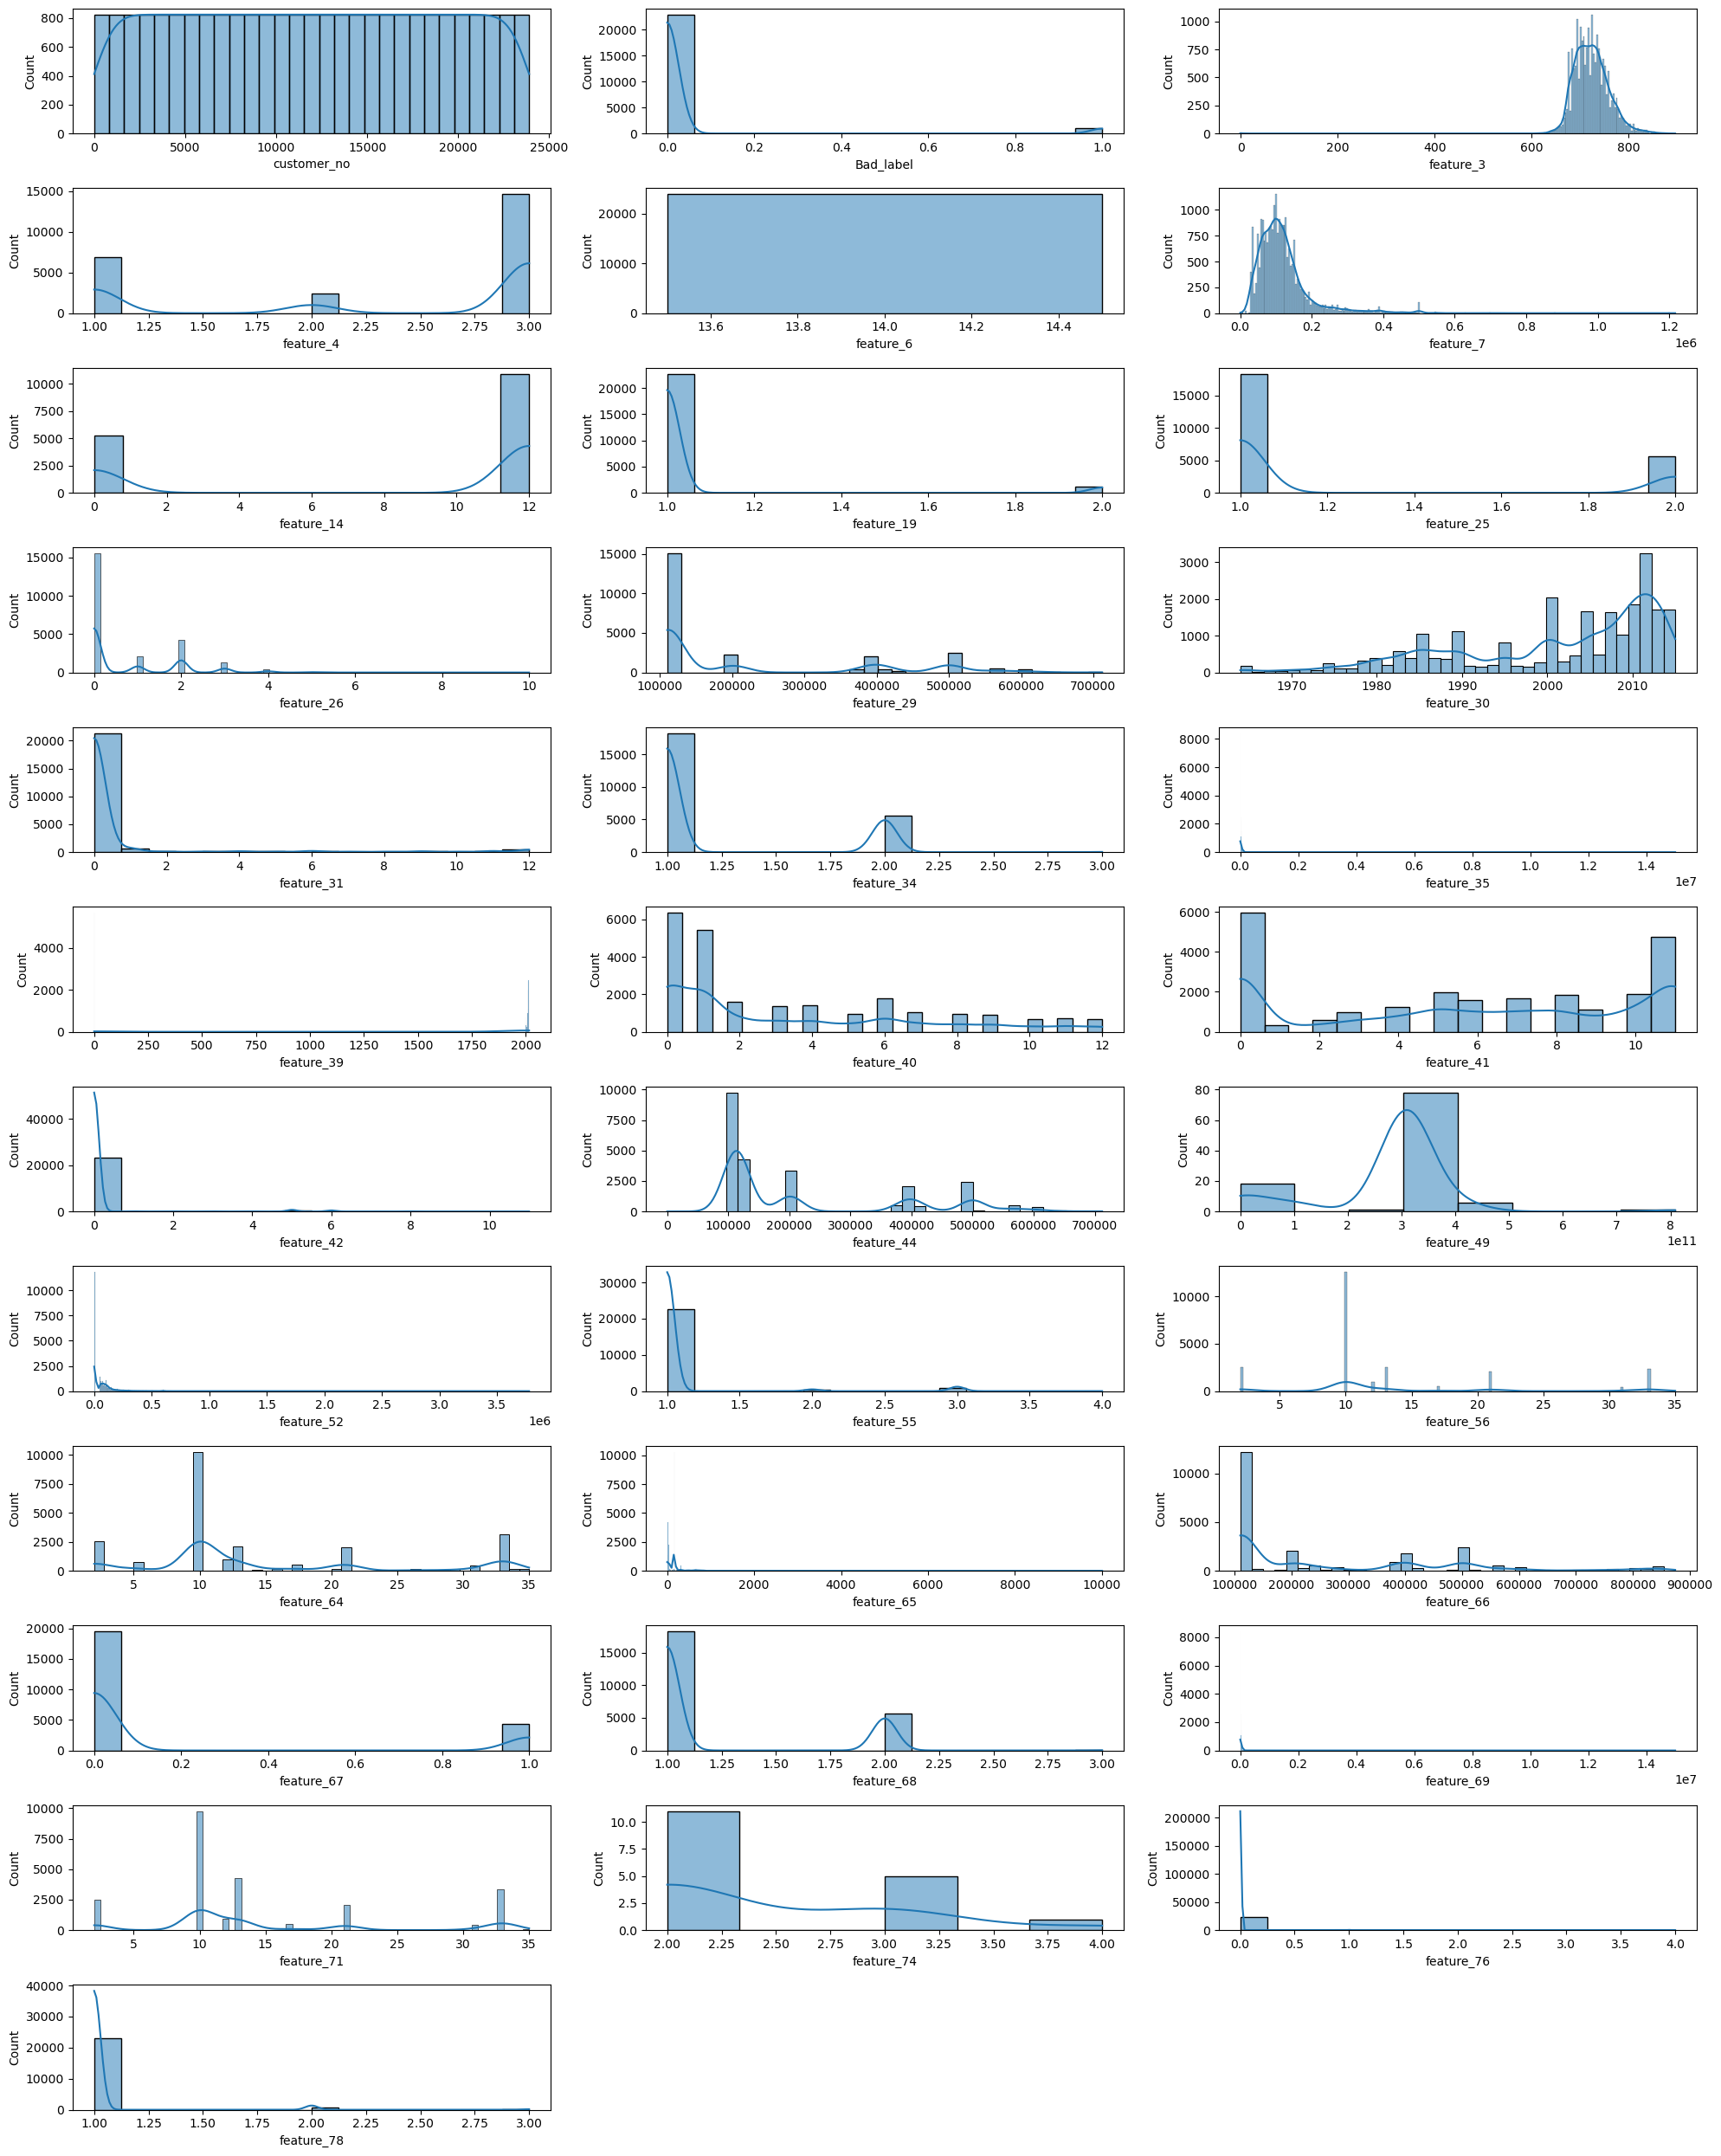

In [32]:
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for i in data1:
    plt.subplot(12,3,plotnumber) 
    sns.histplot(x=i, data=data1,kde=True)
    plotnumber+=1
plt.tight_layout()

## Insights from Univariate Analysis

####  In column "Customer_no" ,all the values are in same range.

#### The target column " Bad_label" has maximum number of zeros as compared to 1.


<AxesSubplot:xlabel='Bad_label', ylabel='count'>

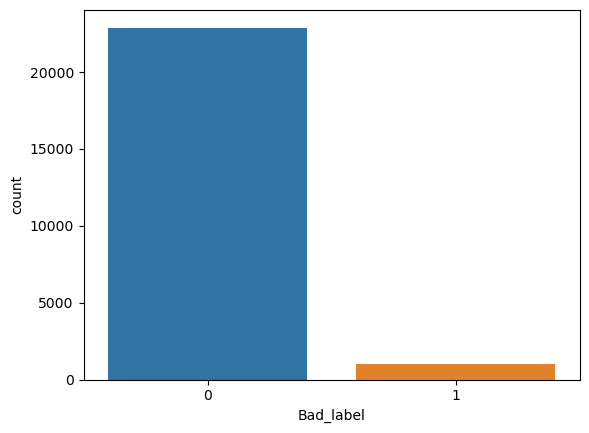

In [33]:
sns.countplot(x=df.Bad_label)

#### From above plot we can observe that the dependent variable "Bad_label" has "0" as  highest value,and "1" as lowest value counts.dataset is highly imbalanced.

### Bivariate Analysis

#### Checking relationship with target variable

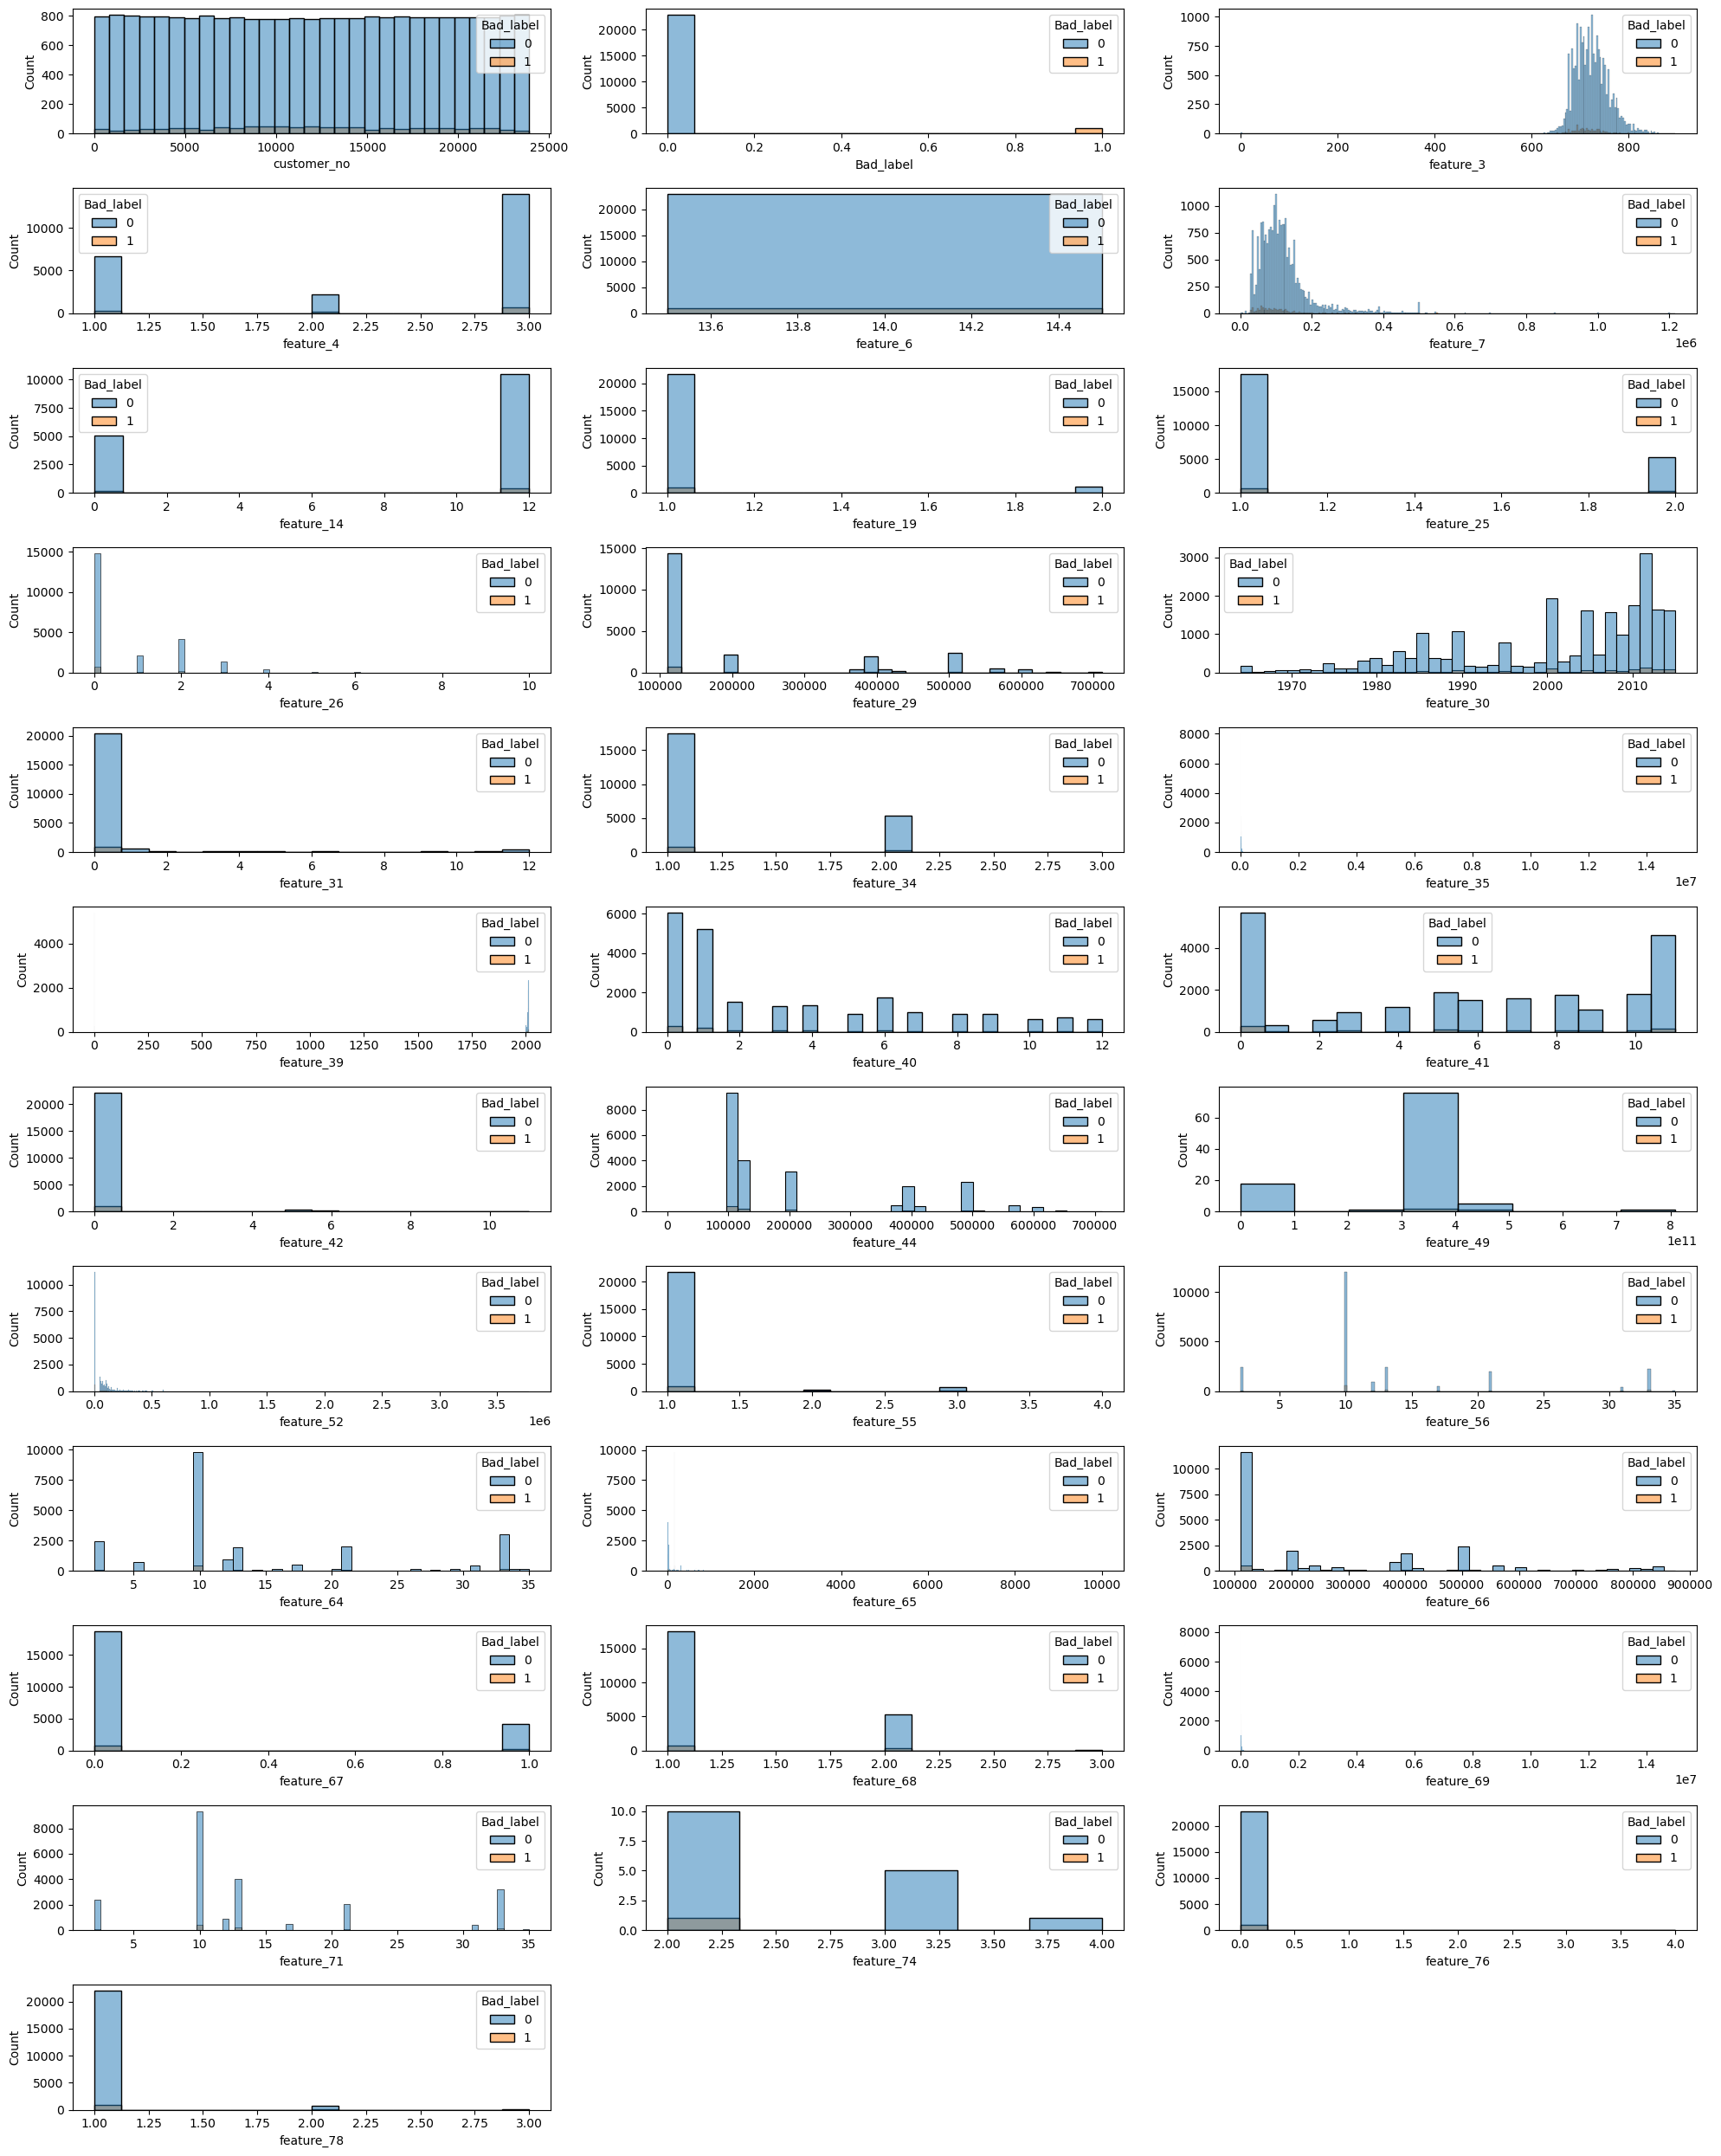

In [34]:
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for i in data1:
    plt.subplot(12,3,plotnumber) 
    sns.histplot(x=i, data=data1,hue="Bad_label")
    plotnumber+=1
plt.tight_layout()

# Data Preprocessing

## Handling null values

In [35]:
(df.isnull().sum()/23896)*100 # Checking for percentage of null values

customer_no         0.000000
dt_opened           0.000000
entry_time          0.062772
feature_1           0.062772
feature_2          11.868095
feature_3          11.868095
feature_4           0.062772
feature_5           0.062772
feature_6           0.062772
feature_7           0.062772
feature_8          94.722966
feature_9          94.722966
feature_10         99.786575
feature_11          0.062772
feature_12          0.062772
feature_13         54.419150
feature_14         32.361065
feature_15          0.096250
feature_16          0.112990
feature_17         95.702210
feature_18         99.924674
feature_19          0.062772
feature_20          0.000000
feature_21          0.062772
feature_22          0.000000
feature_23          0.062772
feature_24          2.678273
feature_25          0.062772
feature_26          0.062772
feature_27         15.220121
feature_28          0.062772
feature_29          0.062772
feature_30          0.062772
feature_31          0.062772
feature_32    

#### Visualization of null values

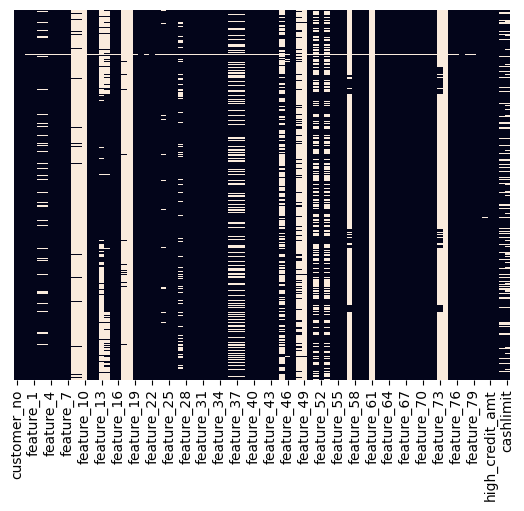

In [36]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
plt.show()

In [37]:
null_values=pd.DataFrame()
null_values['per']=df.isnull().sum()/len(df)*100
null_values['count']=df.isnull().sum()

In [38]:
list(null_values[null_values['per']>50].index) # list of columns having null values more than 50%

['feature_8',
 'feature_9',
 'feature_10',
 'feature_13',
 'feature_17',
 'feature_18',
 'feature_45',
 'feature_48',
 'feature_49',
 'feature_57',
 'feature_61',
 'feature_73',
 'feature_74']

In [39]:
# dropping columns having null values more than 50%
df.drop(list(null_values[null_values['per']>50].index), axis=1, inplace=True)

#### filling null values 

In [40]:
df.dt_opened=df.dt_opened.fillna(df.dt_opened.mode()[0])
df.entry_time=df.dt_opened.fillna(df.dt_opened.mode()[0])
df.feature_1=df.feature_1.fillna(df.feature_1.mode()[0])
df.feature_2=df.feature_2.fillna(df.feature_2.mode()[0])
df.feature_3=df.feature_3.fillna(df.feature_3.mode()[0])
df.feature_4=df.feature_4.fillna(df.feature_4.mode()[0])
df.feature_5=df.feature_5.fillna(df.feature_5.mode()[0])
df.feature_7=df.feature_7.fillna(df.feature_7.mode()[0])
df.feature_11=df.feature_11.fillna(df.feature_11.mode()[0])
df.feature_12=df.feature_12.fillna(df.feature_12.mode()[0])
df.feature_14=df.feature_14.fillna(df.feature_14.mode()[0])
df.feature_15=df.feature_15.fillna(df.feature_15.mode()[0])
df.feature_16=df.feature_16.fillna(df.feature_16.mode()[0])
df.feature_19=df.feature_19.fillna(df.feature_19.mode()[0])
df.feature_20=df.feature_20.fillna(df.feature_20.mode()[0])
df.feature_21=df.feature_21.fillna(df.feature_21.mode()[0])
df.feature_22=df.feature_22.fillna(df.feature_22.mode()[0])
df.feature_23=df.feature_23.fillna(df.feature_23.mode()[0])
df.feature_24=df.feature_24.fillna(df.feature_24.mode()[0])
df.feature_25=df.feature_25.fillna(df.feature_25.mode()[0])
df.feature_26=df.feature_26.fillna(df.feature_26.mode()[0])
df.feature_27=df.feature_27.fillna(df.feature_27.mode()[0])
df.feature_28=df.feature_28.fillna(df.feature_28.mode()[0])
df.feature_29=df.feature_29.fillna(df.feature_29.mode()[0])
df.feature_30=df.feature_30.fillna(df.feature_30.mode()[0])
df.feature_31=df.feature_31.fillna(df.feature_31.mode()[0])
df.feature_32=df.feature_32.fillna(df.feature_32.mode()[0])
df.feature_33=df.feature_33.fillna(df.feature_33.mode()[0])
df.feature_34=df.feature_34.fillna(df.feature_34.mode()[0])
df.feature_35=df.feature_35.fillna(df.feature_35.mode()[0])
df.feature_36=df.feature_36.fillna(df.feature_36.mode()[0])
df.feature_37=df.feature_37.fillna(df.feature_37.mode()[0])
df.feature_38=df.feature_38.fillna(df.feature_38.mode()[0])
df.feature_39=df.feature_39.fillna(df.feature_39.mode()[0])
df.feature_40=df.feature_40.fillna(df.feature_40.mode()[0])
df.feature_41=df.feature_41.fillna(df.feature_41.mode()[0])
df.feature_42=df.feature_42.fillna(df.feature_42.mode()[0])
df.feature_43=df.feature_43.fillna(df.feature_43.mode()[0])
df.feature_44=df.feature_44.fillna(df.feature_44.mode()[0])


In [41]:
df.feature_46=df.feature_46.fillna(df.feature_46.mode()[0])
df.feature_47=df.feature_47.fillna(df.feature_47.mode()[0])
df.feature_50=df.feature_50.fillna(df.feature_50.mode()[0])
df.feature_51=df.feature_51.fillna(df.feature_51.mode()[0])
df.feature_52=df.feature_52.fillna(df.feature_52.mode()[0])
df.feature_53=df.feature_53.fillna(df.feature_53.mode()[0])
df.feature_55=df.feature_55.fillna(df.feature_55.mode()[0])
df.feature_56=df.feature_56.fillna(df.feature_56.mode()[0])
df.feature_58=df.feature_58.fillna(df.feature_58.mode()[0])
df.feature_59=df.feature_59.fillna(df.feature_59.mode()[0])
df.feature_60=df.feature_60.fillna(df.feature_60.mode()[0])
df.feature_62=df.feature_62.fillna(df.feature_62.mode()[0])
df.feature_63=df.feature_63.fillna(df.feature_63.mode()[0])
df.feature_64=df.feature_64.fillna(df.feature_64.mode()[0])
df.feature_65=df.feature_65.fillna(df.feature_65.mode()[0])
df.feature_66=df.feature_66.fillna(df.feature_66.mode()[0])
df.feature_67=df.feature_67.fillna(df.feature_67.mode()[0])
df.feature_68=df.feature_68.fillna(df.feature_68.mode()[0])
df.feature_69=df.feature_69.fillna(df.feature_69.mode()[0])
df.feature_70=df.feature_70.fillna(df.feature_70.mode()[0])
df.feature_71=df.feature_71.fillna(df.feature_71.mode()[0])
df.feature_72=df.feature_72.fillna(df.feature_72.mode()[0])
df.feature_75=df.feature_75.fillna(df.feature_75.mode()[0])
df.feature_76=df.feature_76.fillna(df.feature_76.mode()[0])
df.feature_77=df.feature_77.fillna(df.feature_77.mode()[0])
df.feature_78=df.feature_78.fillna(df.feature_78.mode()[0])
df.feature_79=df.feature_79.fillna(df.feature_79.mode()[0])
df.customer_no=df.customer_no.fillna(df.customer_no.median())
df.high_credit_amt=df.high_credit_amt.fillna(df.high_credit_amt.median())
df.cur_balance_amt=df.cur_balance_amt.fillna(df.cur_balance_amt.mode()[0])
df.enq_amt=df.enq_amt.fillna(df.enq_amt.median())
df.creditlimit=df.creditlimit.fillna(df.creditlimit.mode()[0])
df.cashlimit=df.cashlimit.fillna(df.cashlimit.mode()[0])
df.loc[df.feature_6.isnull()==True,"feature_6"]=15.0
df.loc[df.feature_54.isnull()==True,"feature_54"]='18-Jun-16'

In [42]:
(df.isnull().sum()/23896)*100 # no null values left

customer_no        0.0
dt_opened          0.0
entry_time         0.0
feature_1          0.0
feature_2          0.0
feature_3          0.0
feature_4          0.0
feature_5          0.0
feature_6          0.0
feature_7          0.0
feature_11         0.0
feature_12         0.0
feature_14         0.0
feature_15         0.0
feature_16         0.0
feature_19         0.0
feature_20         0.0
feature_21         0.0
feature_22         0.0
feature_23         0.0
feature_24         0.0
feature_25         0.0
feature_26         0.0
feature_27         0.0
feature_28         0.0
feature_29         0.0
feature_30         0.0
feature_31         0.0
feature_32         0.0
feature_33         0.0
feature_34         0.0
feature_35         0.0
feature_36         0.0
feature_37         0.0
feature_38         0.0
feature_39         0.0
feature_40         0.0
feature_41         0.0
feature_42         0.0
feature_43         0.0
feature_44         0.0
feature_46         0.0
feature_47         0.0
feature_50 

In [43]:
df.head(2)

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_11,feature_12,feature_14,feature_15,feature_16,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,18-Apr-15,18-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,Y,IS1,0.0,159,4284,1.0,ADFPNXXXXX,03-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,Graduate,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Mumbai,400059.0,PAN Card,ADFPNXXXXX,Y,State Bank of India,0.0,01-Jun-13,17-Jun-16,1.0,21.0,Y,Y,N,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,0000-00-00,0.0,98332XXXXX,1.0,N,0,3500000500000500005000010001000100010001000150...,2528846125459139765171256290596200000020000009...,2528846588820003759832549017546780000093630000,250000420000,168000
1,10,30-May-15,30-May-15,Insignia,27-May-15,784.0,1.0,Card Setup,14.0,1017000.0,Y,IS2,0.0,88,5785,1.0,AAFPDXXXXX,09-Oct-69,98100XXXXX,N,@GMAIL.COM,1.0,3.0,Graduate,Gurgaon,122011.0,1969.0,0.0,Self,Y,2.0,1.0,Private Ltd. Co.,Banking/Financial Services,MANAGER,0.0,0.0,0.0,0.0,Mumbai,400025.0,PAN Card,AAFPDXXXXX,N,HDFC Bank,0.0,01-Jun-14,17-Jun-16,1.0,13.0,N,Y,N,Y,1969-0,13.0,3.0,122011.0,0.0,2.0,1.0,Nov-00,21.0,R,0000-00-00,0.0,98100XXXXX,1.0,N,0,2000000200000002000000055000005500000100050000...,1111113565675230005500000531458600000111851500...,068994000178725000000,405000,243000


# Handling Categorical Columns (Encoding)

In [44]:
df[['enq_amt', 'high_credit_amt', 'cur_balance_amt']]=df[['enq_amt', 'high_credit_amt', 'cur_balance_amt']].astype("str")

#### Using Label Encoding Method

In [45]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
for column in df.columns:
    if df[column].dtype=="object":
        df[column]=lb.fit_transform(df[column])

In [46]:
(df.dtypes=="object").sum() # No object values left

0

In [47]:
df.head(2)

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_11,feature_12,feature_14,feature_15,feature_16,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,101,101,1,108,650.0,2.0,0,14.0,500000.0,1,3,0.0,25,41,1.0,959,936,2513,0,473,1.0,2.0,5,39,400610.0,1965.0,0.0,4,1,2.0,90000.0,6,1,2629,0.0,0.0,0.0,0.0,43,400059.0,2,1148,1,9,0.0,104,0,1.0,21.0,1,1,0,1,1,21.0,15.0,400610.0,0.0,2.0,90000.0,130,21.0,1,0,0.0,2408,1.0,0,0,14226,9173,12616,4429,2847
1,10,189,189,1,247,784.0,1.0,0,14.0,1017000.0,1,4,0.0,81,74,1.0,86,2629,2391,0,196,1.0,3.0,5,23,122011.0,1969.0,0.0,4,1,2.0,1.0,6,1,2629,0.0,0.0,0.0,0.0,43,400025.0,2,309,0,3,0.0,105,0,1.0,13.0,0,1,0,1,13,13.0,3.0,122011.0,0.0,2.0,1.0,130,21.0,1,0,0.0,2287,1.0,0,0,12165,1599,4486,5897,4109


# Handling Outliers

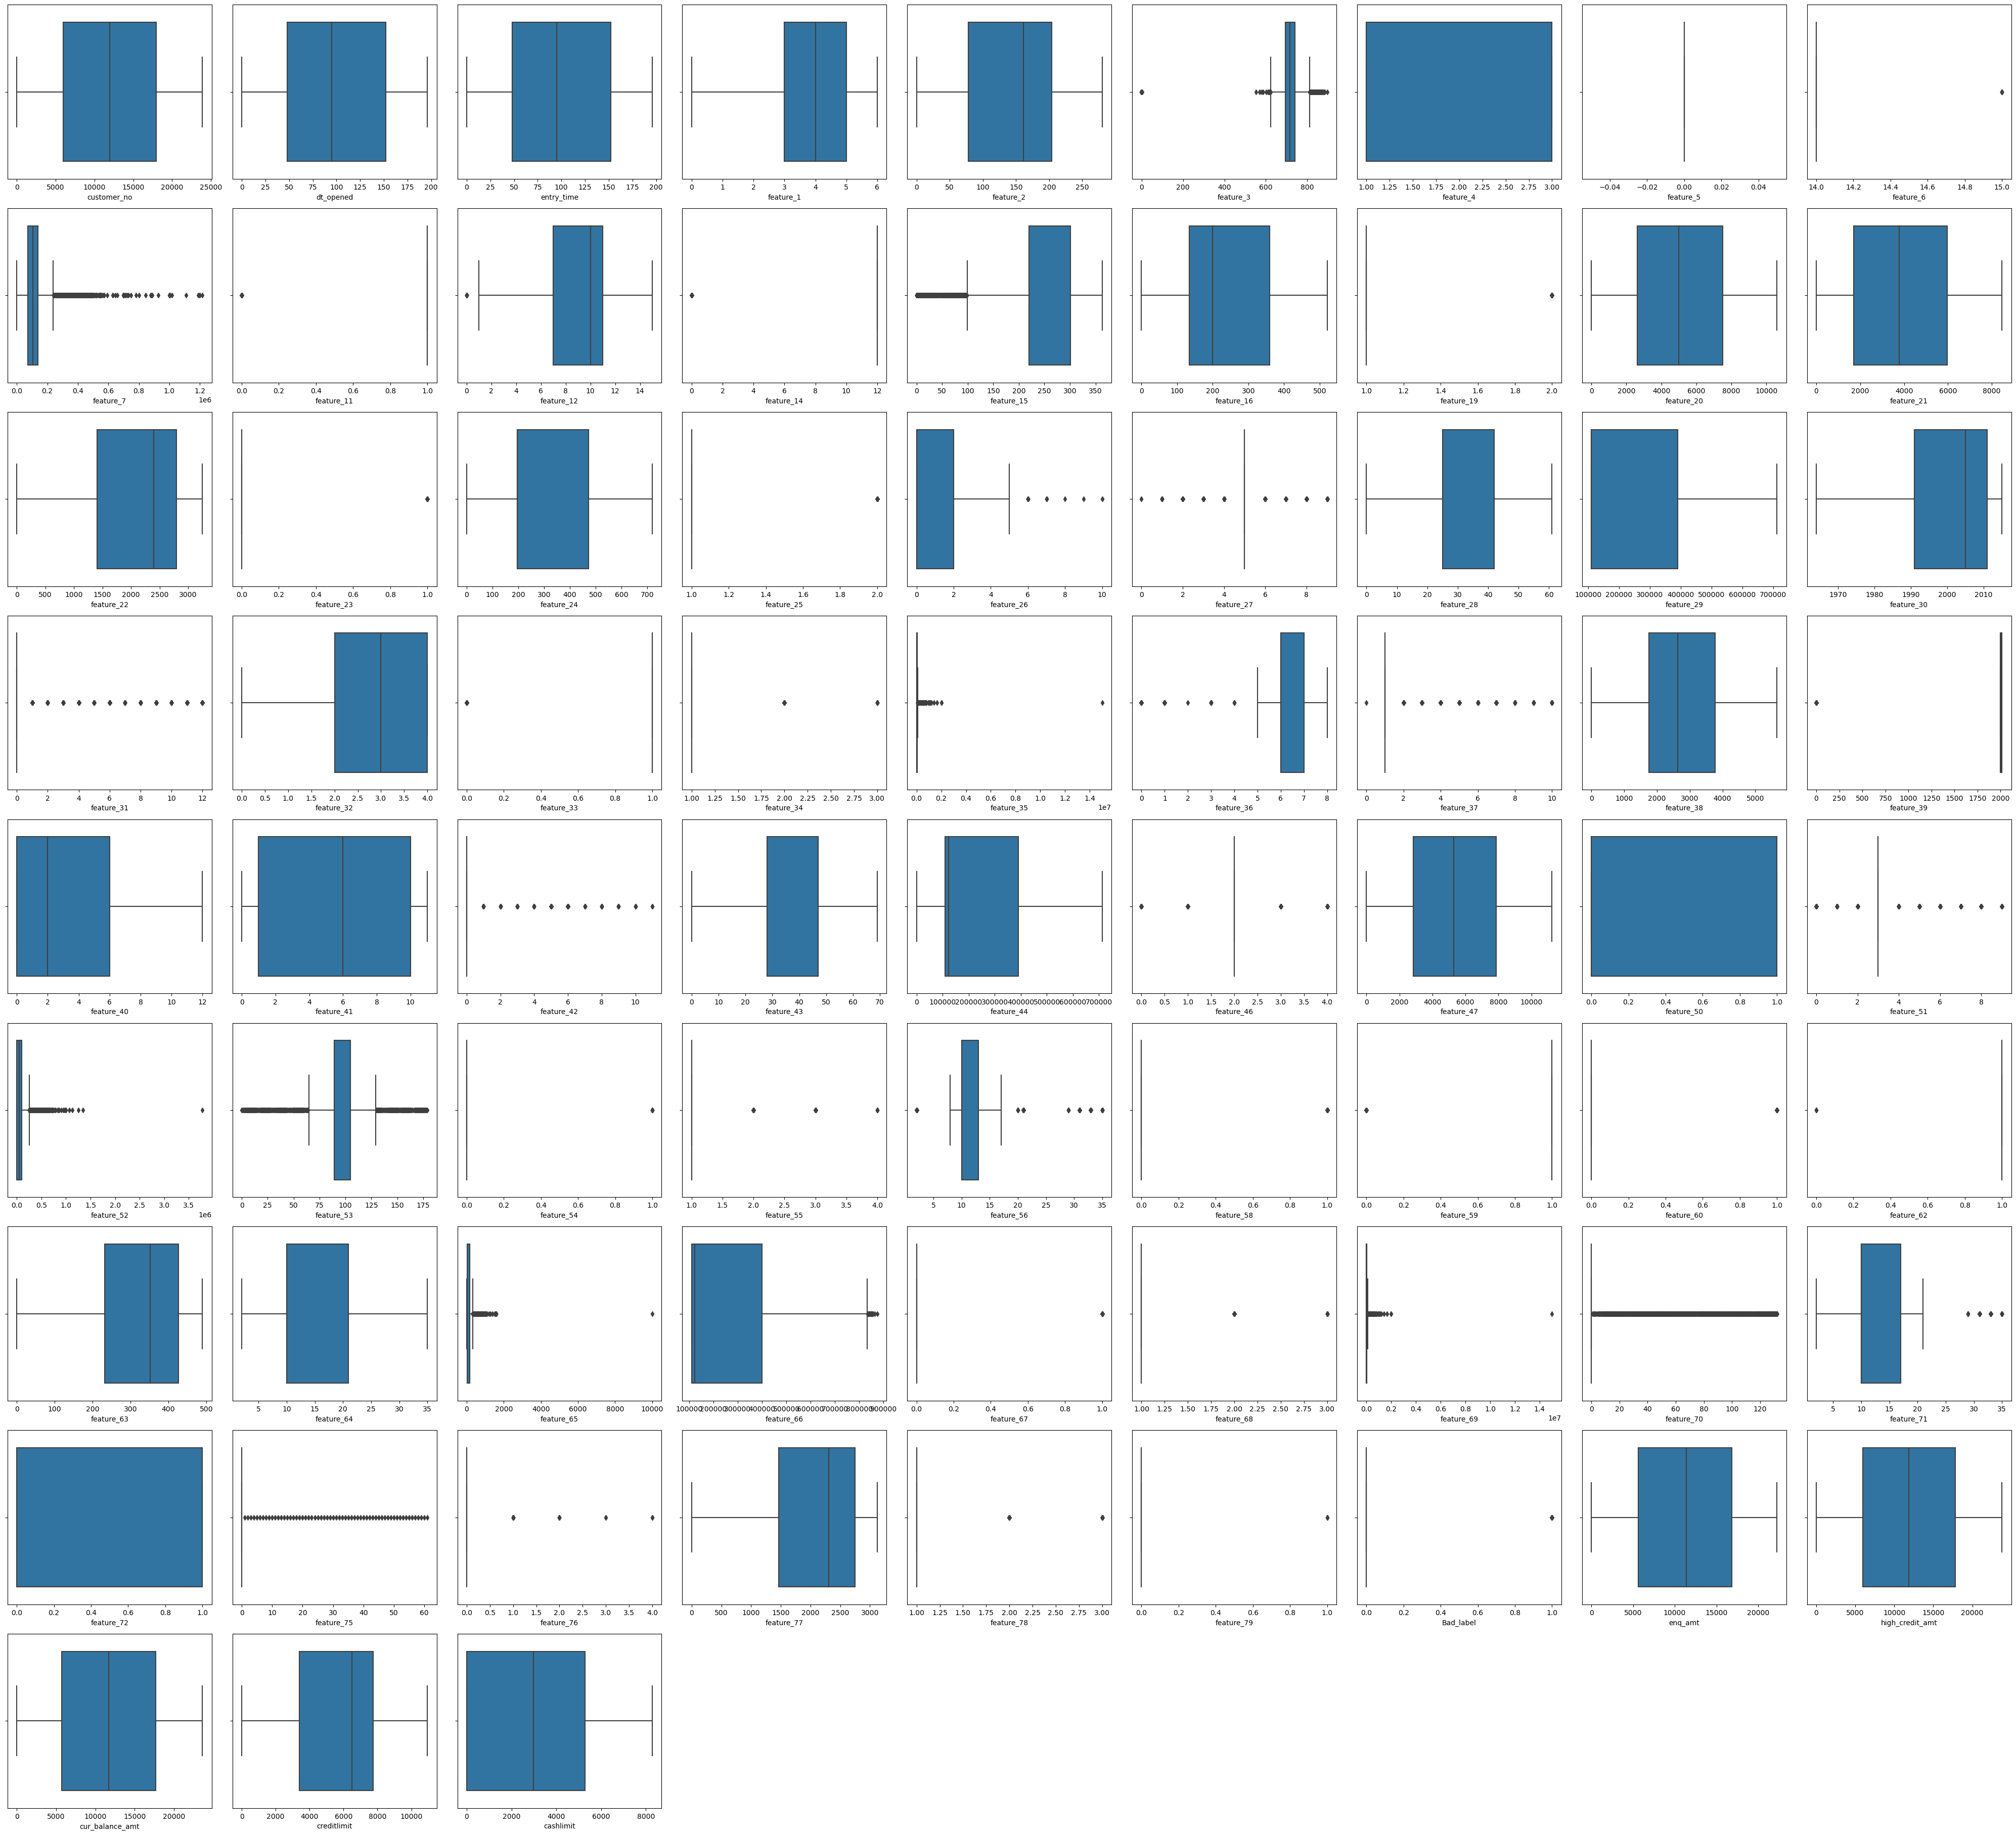

In [48]:
plt.figure(figsize=(40,40),facecolor='white')

plotnumber=1

for column in df:
        ax=plt.subplot(10,9,plotnumber)
        sns.boxplot(x = df[column])
        plotnumber+=1
plt.tight_layout() 

#### We will handle outliers  in further data preprocessing steps.and based on performance of the model

# Feature Selection
## checking correlation

In [49]:
df.corr() # Checking correlation

,customer_no,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_11,feature_12,feature_14,feature_15,feature_16,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
customer_no,1.000000,0.101095,0.101095,-0.821591,-0.034847,0.015329,-0.200976,NaN,0.001014,-0.042026,-0.032704,-0.869226,0.394179,0.192694,-0.052908,-0.003687,0.052246,-0.005858,0.008009,-0.096792,-0.062501,0.035894,-0.308230,0.018561,0.088720,-0.237692,-0.022365,0.199726,-0.165096,-0.043709,-0.008931,-0.053441,0.028949,0.149054,-0.005618,0.009220,0.005499,-0.035443,0.018286,0.068920,-0.233977,0.006816,0.040072,-0.107861,-0.025280,-0.080465,0.016190,0.001014,-0.007239,0.036823,-0.054949,-0.032704,-0.031695,-0.001077,-0.022097,0.052495,0.056029,-0.150694,0.043709,-0.008931,-0.053441,-0.007888,0.064644,-0.028477,-0.002070,-0.003088,0.035765,-0.009862,-0.008111,-0.001673,0.047506,0.002455,0.002284,0.012630,-0.008896
dt_opened,0.101095,1.000000,1.000000,-0.065738,-0.144360,0.007604,-0.083242,NaN,-0.010502,0.000828,-0.000564,-0.077860,-0.027112,0.003949,-0.009222,-0.002658,0.004108,-0.002407,-0.001763,0.000121,-0.004929,0.004131,-0.055019,-0.003988,0.004497,-0.004146,0.003647,0.196254,-0.045276,0.000890,0.011266,0.000721,0.011788,0.049160,0.004588,-0.010307,0.018543,-0.015000,0.007225,-0.002126,-0.002734,0.007033,0.004567,-0.043284,-0.011059,-0.033879,0.017491,-0.010502,-0.002636,-0.014544,0.010641,-0.000564,0.003553,0.009759,0.006912,-0.014581,-0.007204,0.001267,-0.000890,0.011266,0.000721,0.012720,-0.006971,-0.007238,0.004165,0.011205,0.020645,-0.020649,0.001283,-0.017330,0.011298,0.007314,0.013715,0.014217,-0.005861
entry_time,0.101095,1.000000,1.000000,-0.065738,-0.144360,0.007604,-0.083242,NaN,-0.010502,0.000828,-0.000564,-0.077860,-0.027112,0.003949,-0.009222,-0.002658,0.004108,-0.002407,-0.001763,0.000121,-0.004929,0.004131,-0.055019,-0.003988,0.004497,-0.004146,0.003647,0.196254,-0.045276,0.000890,0.011266,0.000721,0.011788,0.049160,0.004588,-0.010307,0.018543,-0.015000,0.007225,-0.002126,-0.002734,0.007033,0.004567,-0.043284,-0.011059,-0.033879,0.017491,-0.010502,-0.002636,-0.014544,0.010641,-0.000564,0.003553,0.009759,0.006912,-0.014581,-0.007204,0.001267,-0.000890,0.011266,0.000721,0.012720,-0.006971,-0.007238,0.004165,0.011205,0.020645,-0.020649,0.001283,-0.017330,0.011298,0.007314,0.013715,0.014217,-0.005861
feature_1,-0.821591,-0.065738,-0.065738,1.000000,0.015692,-0.013196,0.093997,NaN,-0.002835,-0.046432,0.034539,0.961847,-0.519736,-0.151314,0.064228,0.009242,-0.008992,0.008449,-0.028407,0.089708,0.028381,-0.008771,0.143413,-0.013194,-0.084451,0.218883,0.042171,-0.032634,0.041661,0.050642,-0.037314,0.015959,-0.023353,-0.053488,0.011304,0.037332,0.044149,0.051856,-0.005426,-0.065297,0.216131,-0.010199,-0.017680,0.043928,0.014840,0.025621,-0.008909,-0.002835,0.006547,-0.060151,-0.017589,0.034539,-0.012206,-0.000815,0.042973,-0.072848,-0.041358,0.136946,-0.050642,-0.037314,0.015959,-0.041144,-0.081816,0.029757,-0.013229,-0.019054,-0.034601,0.021821,-0.004087,-0.014496,-0.026948,-0.007772,0.007749,0.002176,-0.012550
feature_2,-0.034847,-0.144360,-0.144360,0.015692,1.000000,-0.035369,-0.028700,NaN,0.009760,-0.002345,-0.007303,0.019859,-0.015449,-0.038351,0.031485,0.005815,-0.009305,0.000424,-0.008887,-0.011589,0.006727,0.000130,0.021308,-0.000645,-0.008419,0.038460,0.004218,-0.063739,0.019950,-0.006476,-0.014614

#### The NAN values represents that the column contains constant values.
#### So we will drop the constant columns.

In [50]:
df.drop(["feature_5"],axis=1,inplace=True) 

In [51]:
correlation=df.corr()
threshold=0.9 # setting threshold

# Identify and eliminate highly correlated columns
columns_to_drop=[]
n_cols=len(correlation.columns)
for i in range(n_cols):
    for j in range(i+1, n_cols):
        if abs(correlation.iloc[i, j])>threshold:
            col_i=correlation.columns[i]
            col_j=correlation.columns[j]
            if col_i not in columns_to_drop:
                columns_to_drop.append(col_j)

In [52]:
columns_to_drop # Columns which has correlation more than 90%

['entry_time',
 'feature_12',
 'feature_54',
 'feature_59',
 'feature_55',
 'feature_44',
 'feature_63',
 'feature_67',
 'feature_39',
 'feature_68',
 'feature_70',
 'feature_69']

In [53]:
df.drop(columns_to_drop,axis=1,inplace=True) # dropping highly correlated columns

# Model Creation

#### Selecting dependent and independent values

In [54]:
x=df.drop('Bad_label',axis=1) 
y=df[["Bad_label"]]

In [55]:
x.head() # Independent features

,customer_no,dt_opened,feature_1,feature_2,feature_3,feature_4,feature_6,feature_7,feature_11,feature_14,feature_15,feature_16,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_40,feature_41,feature_42,feature_43,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_56,feature_58,feature_60,feature_62,feature_64,feature_65,feature_66,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,feature_79,enq_amt,high_credit_amt,cur_balance_amt,creditlimit,cashlimit
0,1,101,1,108,650.0,2.0,14.0,500000.0,1,0.0,25,41,1.0,959,936,2513,0,473,1.0,2.0,5,39,400610.0,1965.0,0.0,4,1,2.0,90000.0,6,1,2629,0.0,0.0,0.0,43,2,1148,1,9,0.0,104,21.0,1,0,1,21.0,15.0,400610.0,21.0,1,0,0.0,2408,1.0,0,14226,9173,12616,4429,2847
1,10,189,1,247,784.0,1.0,14.0,1017000.0,1,0.0,81,74,1.0,86,2629,2391,0,196,1.0,3.0,5,23,122011.0,1969.0,0.0,4,1,2.0,1.0,6,1,2629,0.0,0.0,0.0,43,2,309,0,3,0.0,105,13.0,0,0,1,13.0,3.0,122011.0,21.0,1,0,0.0,2287,1.0,0,12165,1599,4486,5897,4109
2,100,142,6,108,780.0,3.0,14.0,137000.0,1,12.0,301,130,1.0,7650,8185,2224,0,196,1.0,2.0,8,42,110071.0,1995.0,0.0,4,1,1.0,40000.0,6,7,1678,1.0,10.0,0.0,28,2,7724,1,9,59000.0,131,10.0,0,0,1,10.0,157.0,110071.0,13.0,0,0,0.0,2134,1.0,0,16476,21665,16505,5080,8257
3,1000,173,6,67,780.0,3.0,14.0,293000.0,1,12.0,301,130,1.0,9294,131,2859,0,473,1.0,3.0,8,23,122001.0,2011.0,0.0,3,0,1.0,40000.0,6,1,4276,1.0,11.0,0.0,28,2,9350,1,9,225000.0,131,13.0,0,0,1,26.0,226.0,754004.0,13.0,0,0,0.0,2745,2.0,0,2881,18550,14449,4209,7371
4,10000,192,4,87,700.0,3.0,14.0,145000.0,1,12.0,301,138,1.0,10032,3506,2855,0,196,1.0,0.0,5,42,110037.0,2006.0,1.0,3,0,2.0,1.0,6,1,2629,0.0,0.0,0.0,47,2,10080,1,2,0.0,57,10.0,0,0,1,5.0,283.0,843118.0,10.0,0,0,0.0,3123,1.0,0,22177,18164,9367,7821,2


In [56]:
y.head() # Dependent/Target feature

,Bad_label
0,0
1,0
2,0
3,0
4,0


#### Scaling of data 

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [58]:
x_scaled=scaler.fit_transform(x)

In [59]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.3,random_state=42)

#### Balancing the data

In [60]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [61]:
sm=SMOTE()
x_sm,y_sm=sm.fit_resample(x_train,y_train)

In [62]:
df.Bad_label.value_counts()

0    22892
1     1004
Name: Bad_label, dtype: int64

In [63]:
print(y_train.value_counts())

Bad_label
0            16006
1              721
dtype: int64


In [64]:
print(y_sm.value_counts()) # balanced data

Bad_label
0            16006
1            16006
dtype: int64


# Model building
## Logistic Regression

In [65]:
LR=LogisticRegression()
LR.fit(x_sm,y_sm)

LogisticRegression()

In [66]:
y_pred=LR.predict(x_test)  # for testing data
y_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [67]:
from sklearn.metrics import accuracy_score,r2_score,confusion_matrix,classification_report
acc=accuracy_score(y_test,y_pred)
acc

0.6063607197656576

In [68]:
y_pred_train=LR.predict(x_sm)
acc_train=accuracy_score(y_sm,y_pred_train)
acc_train

0.6518180682244158

In [69]:
print(confusion_matrix(y_test,y_pred))

[[4189 2697]
 [ 125  158]]


In [70]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.61      0.75      6886
           1       0.06      0.56      0.10       283

    accuracy                           0.61      7169
   macro avg       0.51      0.58      0.42      7169
weighted avg       0.93      0.61      0.72      7169



In [71]:
cross_val=cross_val_score(LR,x_sm,y_sm,cv=3,scoring="f1") # cross validation score
cross=cross_val.mean()
cross

0.6614739581240401

In [72]:
gini=2*roc_auc_score(y_test,y_pred)-1  # Calculating Gini score
gini

0.16663964062896097

#### Plotting actual v/s predicted values

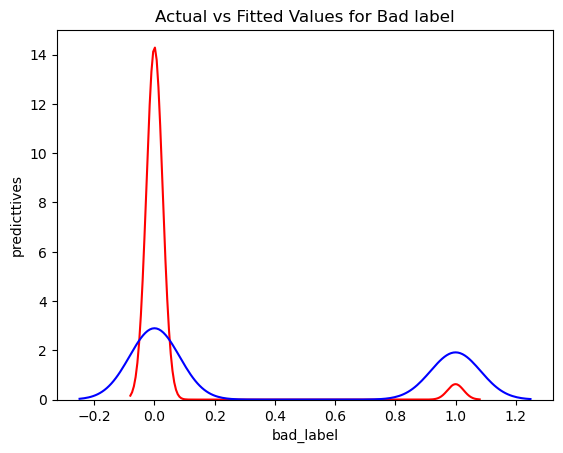

In [73]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label")
plt.ylabel("predicttives")

plt.show()
plt.close()

# SVM

In [74]:
sv=SVC()
sv.fit(x_sm,y_sm)

SVC()

In [75]:
y_pred2=sv.predict(x_test) # for testing data
y_pred2

array([1, 0, 0, ..., 0, 0, 0], dtype=int64)

In [76]:
acc2=accuracy_score(y_test,y_pred2) 
acc2

0.862602873483052

In [77]:
y_pred_train2=sv.predict(x_sm) # for training data
y_pred_train2

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [78]:
acc_train2=accuracy_score(y_sm,y_pred_train2) 
acc_train2

0.9150318630513558

In [79]:
print(confusion_matrix(y_test,y_pred2))

[[6139  747]
 [ 238   45]]


In [80]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.89      0.93      6886
           1       0.06      0.16      0.08       283

    accuracy                           0.86      7169
   macro avg       0.51      0.53      0.50      7169
weighted avg       0.93      0.86      0.89      7169



In [81]:
cross_val2=cross_val_score(sv,x_sm,y_sm,cv=3,scoring="f1")
cross2=cross_val2.mean()
cross2

0.8903053776146154

In [82]:
gini2=2*roc_auc_score(y_test,y_pred2)-1
gini2

0.05052962481359735

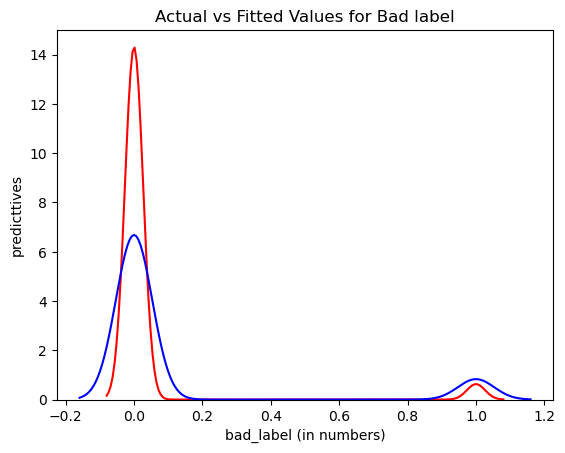

In [83]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred2,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label (in numbers)")
plt.ylabel("predicttives")

plt.show()
plt.close()

# Decision Tree

In [84]:
dt=DecisionTreeClassifier()
dt.fit(x_sm,y_sm)

DecisionTreeClassifier()

In [85]:
y_pred3=dt.predict(x_test)


In [86]:
acc3=accuracy_score(y_test,y_pred3) # for testing data
acc3

0.8892453619751709

In [87]:
y_pred_train3=dt.predict(x_sm)


In [88]:
acc_train3=accuracy_score(y_sm,y_pred_train3) # for training data
acc_train3

1.0

In [89]:
print(confusion_matrix(y_test,y_pred3))

[[6351  535]
 [ 259   24]]


In [90]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      6886
           1       0.04      0.08      0.06       283

    accuracy                           0.89      7169
   macro avg       0.50      0.50      0.50      7169
weighted avg       0.92      0.89      0.91      7169



In [91]:
cross_val3=cross_val_score(dt,x_sm,y_sm,cv=3,scoring="f1")
cross3=cross_val3.mean()
cross3

0.9226395005862574

In [92]:
gini3=2*roc_auc_score(y_test,y_pred3)-1
gini3

0.007111782086663299

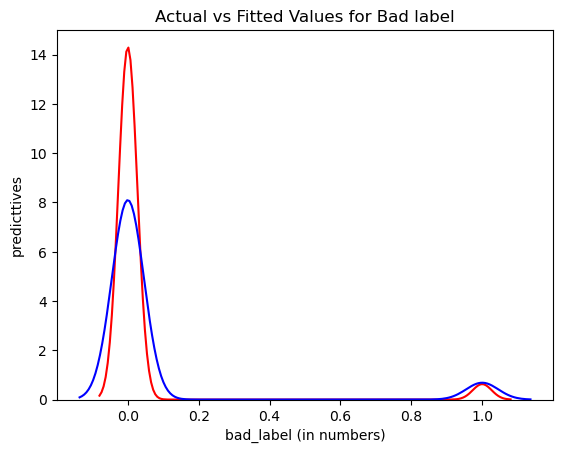

In [93]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred3,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label (in numbers)")
plt.ylabel("predicttives")

plt.show()
plt.close()

# Randonm forest¶

In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rf=RandomForestClassifier()
rf.fit(x_sm,y_sm)


RandomForestClassifier()

In [96]:
y_pred4=rf.predict(x_test)

In [97]:

acc4=accuracy_score(y_test,y_pred4)
acc4

0.9594085646533687

In [98]:
y_pred_train4=rf.predict(x_sm)

In [99]:

acc_train4=accuracy_score(y_sm,y_pred_train4)
acc_train4

1.0

In [100]:
print(confusion_matrix(y_test,y_pred4))

[[6878    8]
 [ 283    0]]


In [101]:
print(classification_report(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6886
           1       0.00      0.00      0.00       283

    accuracy                           0.96      7169
   macro avg       0.48      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169



In [102]:
cross_val4=cross_val_score(rf,x_sm,y_sm,cv=3,scoring="f1")
cross4=cross_val4.mean()
cross4

0.9826391169834502

In [103]:
gini4=2*roc_auc_score(y_test,y_pred4)-1
gini4

-0.0011617775196050006

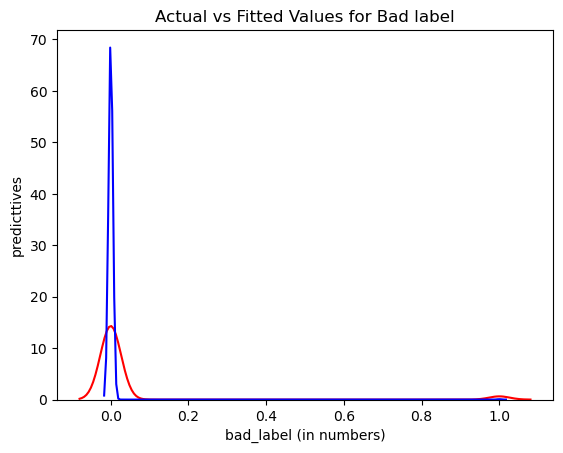

In [104]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred4,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label (in numbers)")
plt.ylabel("predicttives")

plt.show()
plt.close()

# Gradient Boosting

In [105]:
gb=GradientBoostingClassifier()
gb.fit(x_sm,y_sm)

GradientBoostingClassifier()

In [106]:
y_pred5=gb.predict(x_test)

In [107]:
acc5=accuracy_score(y_test,y_pred5)
acc5

0.948667875575394

In [108]:
y_pred_train5=gb.predict(x_sm)

In [109]:

acc_train5=accuracy_score(y_sm,y_pred_train5)
acc_train5

0.9584530800949644

In [110]:
print(confusion_matrix(y_test,y_pred5))

[[6788   98]
 [ 270   13]]


In [111]:
print(classification_report(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      6886
           1       0.12      0.05      0.07       283

    accuracy                           0.95      7169
   macro avg       0.54      0.52      0.52      7169
weighted avg       0.93      0.95      0.94      7169



In [112]:
cross_val5=cross_val_score(gb,x_sm,y_sm,cv=3,scoring="f1")


In [113]:
cross5=cross_val5.mean()
cross5

0.9548462664791145

In [114]:
gini5=2*roc_auc_score(y_test,y_pred5)-1
gini5

0.03170462114455619

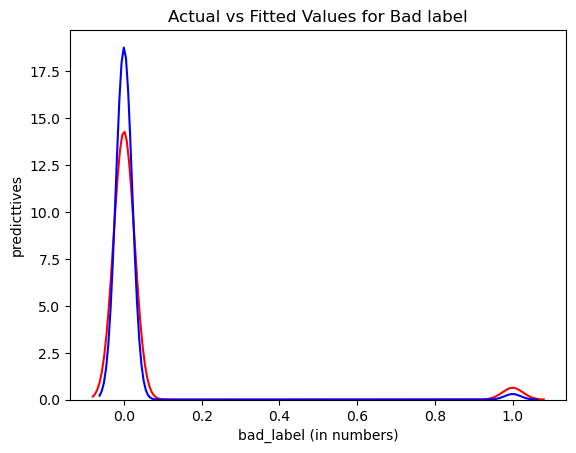

In [115]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred5,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label (in numbers)")
plt.ylabel("predicttives")

plt.show()
plt.close()

# Xg boost

In [116]:
from xgboost import XGBClassifier


In [117]:
xg=XGBClassifier()
xg.fit(x_sm,y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [118]:
y_pred6=xg.predict(x_test)

In [119]:
acc6=accuracy_score(y_test,y_pred6)
acc6

0.9587111173106431

In [120]:
y_pred_train6=xg.predict(x_sm)

In [121]:

acc_train6=accuracy_score(y_sm,y_pred_train6)
acc_train6

0.9925965263026365

In [122]:
print(confusion_matrix(y_test,y_pred6))

[[6873   13]
 [ 283    0]]


In [123]:
print(classification_report(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6886
           1       0.00      0.00      0.00       283

    accuracy                           0.96      7169
   macro avg       0.48      0.50      0.49      7169
weighted avg       0.92      0.96      0.94      7169



In [124]:
cross_val6=cross_val_score(xg,x_sm,y_sm,cv=3,scoring="f1")
cross6=cross_val6.mean()
cross6

0.973999468314526

In [125]:
gini6=2*roc_auc_score(y_test,y_pred6)-1
gini6

-0.0018878884693581677

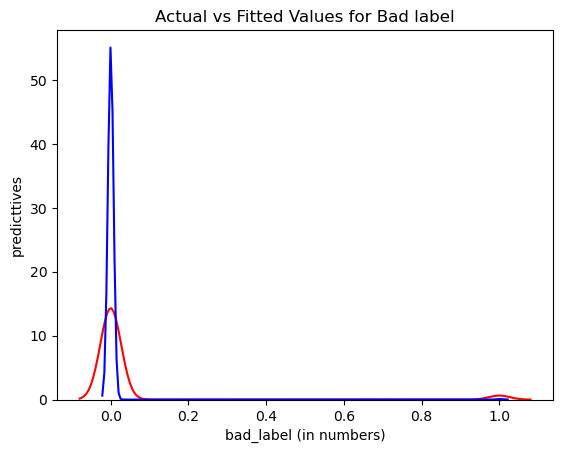

In [126]:
ax1=sns.distplot(df["Bad_label"],hist=False,color="r",label="Actual Values")
sns.distplot(y_pred6,hist=False,color="b",label="Fitted Values",ax=ax1)

plt.title("Actual vs Fitted Values for Bad label")
plt.xlabel("bad_label (in numbers)")
plt.ylabel("predicttives")

plt.show()
plt.close()

### Comaparing all the results using dictionary

In [127]:
dict={"model":["LogisticRegression","SVM","decision tree","random forest","gradient boosting","xgboost"],
     'accuracy_train':[acc_train,acc_train2,acc_train3,acc_train4,acc_train5,acc_train6],
     "accuracy_test":[acc,acc2,acc3,acc4,acc5,acc6],
      "Cross_val_score":[cross,cross2,cross3,cross4,cross5,cross6],
      "Gini_value":[gini,gini2,gini3,gini4,gini5,gini6]
      }

In [128]:
scores=pd.DataFrame(dict)
scores

,model,accuracy_train,accuracy_test,Cross_val_score,Gini_value
0,LogisticRegression,0.651818,0.606361,0.661474,0.166640
1,SVM,0.915032,0.862603,0.890305,0.050530
2,decision tree,1.000000,0.889245,0.922640,0.007112
3,random forest,1.000000,0.959409,0.982639,-0.001162
4,gradient boosting,0.958453,0.948668,0.954846,0.031705
5,xgboost,0.992597,0.958711,0.973999,-0.001888


In [129]:
score=scores.sort_values(by="Cross_val_score")
score

,model,accuracy_train,accuracy_test,Cross_val_score,Gini_value
0,LogisticRegression,0.651818,0.606361,0.661474,0.166640
1,SVM,0.915032,0.862603,0.890305,0.050530
2,decision tree,1.000000,0.889245,0.922640,0.007112
4,gradient boosting,0.958453,0.948668,0.954846,0.031705
5,xgboost,0.992597,0.958711,0.973999,-0.001888
3,random forest,1.000000,0.959409,0.982639,-0.001162


# CONCLUSION:

### For this data set, the algorithms showing better performance are:
### 1.XGBoost
### 2.Random Forest

### XGBoost have the accuracy score of 95% and cross validation score of 97%.
### XGBoost and random forest have almost equal accuracy  score.
### Best accuracy and cross validation score is shown by random forest. 
### Thus, Random forest model is best suited for this data set followed by XGboost .

# CHALLENGES FACED :

In [ ]:
1.Faced problem while combining all the 3 dataset because of the size and complexity of the data set.
2.Visualization was hard due to number of features.
3.As there were many missing values, Simple Imputer was used to fill those null values.
4.there was not enough computational resource to run the hyper parameter tuning.
5.algorithms took more than enough time to run .
6.Label encoding was done using for loop, since there were many categorical features.
7.demographics features were renamed as features and obscured in accordance with privacy policies,due to this visualization
 was not possible,still tried to get meaningful insights.